In [ ]:
%load_ext autoreload
%autoreload 2

# PMDS

In [24]:
from lib.imports import *
from lib.functions import *
from lib.utils import *
from lib.modules import *
from lib.data import *
from ipynb.fs.defs.losses import *

# Config

In [3]:
cuda_idx = 0
data_config = StaticConfig({
    "sparse": False,
    "pivot": None,
    "init": 'pmds',
    "edge": {
        "index": "full_edge_index",
        "attr": "full_edge_attr"
    }
})

In [4]:
root = '.'
vis_folder = lambda: f'{root}/visualizations/pmds'
metrics_file = lambda suffix: f"{root}/metrics/pmds.pickle"

In [5]:
if cuda_idx is not None and torch.cuda.is_available():
    device = f'cuda:{cuda_idx}'
    nvidia_smi.nvmlInit()
    cuda = nvidia_smi.nvmlDeviceGetHandleByIndex(cuda_idx)
else:
    device = 'cpu'
    cuda =  None
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [6]:
G_list = load_G_list(data_path='data/rome', index_file='data_index.txt', cache='G_list.pickle')
data_list = generate_data_list(G_list,
                               sparse=data_config.sparse, 
                               pivot_mode=data_config.pivot,
                               init_mode=data_config.init,
                               edge_index=data_config.edge.index,
                               edge_attr=data_config.edge.attr,
                               pmds_list=pickle.load(open('pmds_list.pickle', 'rb')),
                               device=device,
                               cache='data_list_pmds.pickle')
# train_loader = LazyDeviceMappingDataLoader(data_list[:10000], batch_size=config.batchsize, shuffle=True, device=device)
# val_loader = LazyDeviceMappingDataLoader(data_list[11000:], batch_size=config.batchsize, shuffle=False, device=device)

In [7]:
def test_callback(*, idx, pred, metrics):
    graph_vis(G_list[idx], pred, f"{vis_folder()}/{idx}_{metrics['stress']:.2f}_{metrics['resolution_score']:.2f}.png")

In [8]:
class IdentityModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.p = nn.parameter.Parameter(torch.zeros(1).to(device))
        
    def forward(self, data):
        return data.pos

In [ ]:
class 

In [9]:
model = IdentityModel()

In [10]:
if os.path.isdir(vis_folder()):
    shutil.rmtree(vis_folder())
os.mkdir(vis_folder())

In [11]:
evaluation_criteria = [StressLoss(), NormalizedStressLoss(), EdgeLengthStdLoss()]

100%|██████████| 1000/1000 [02:30<00:00,  6.66it/s]
/opt/conda/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


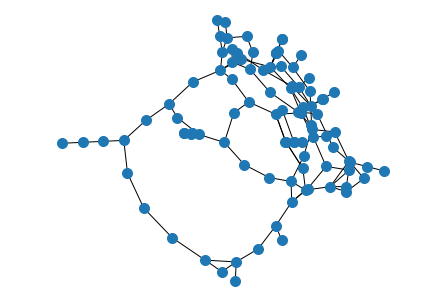

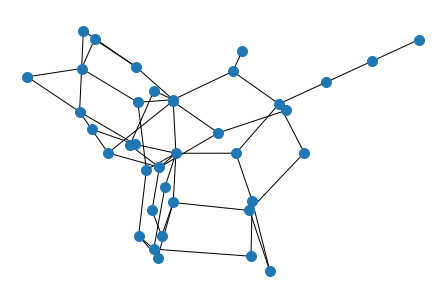

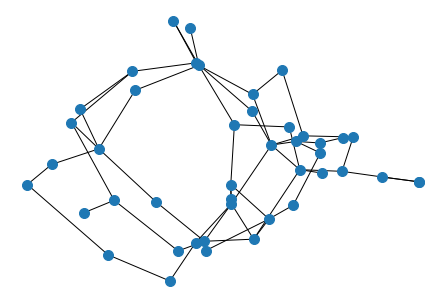

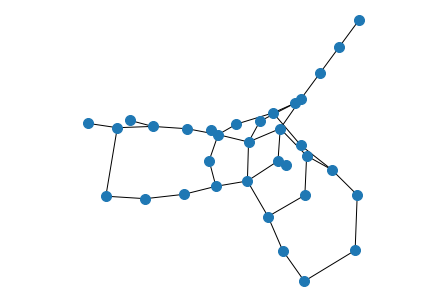

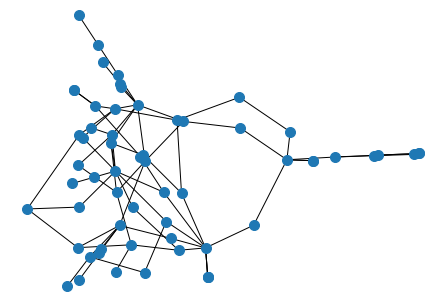

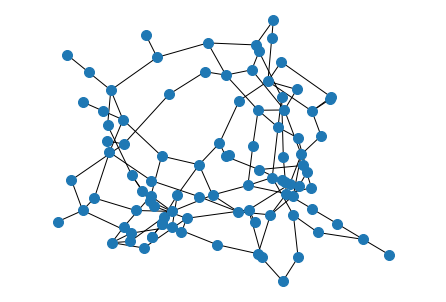

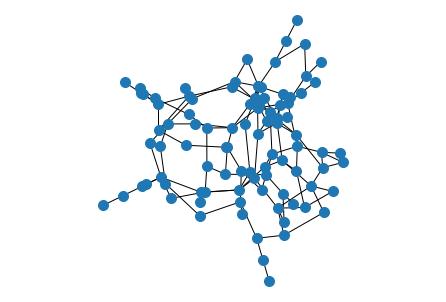

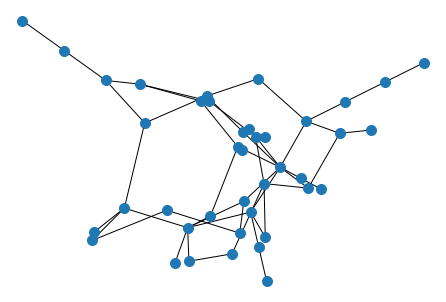

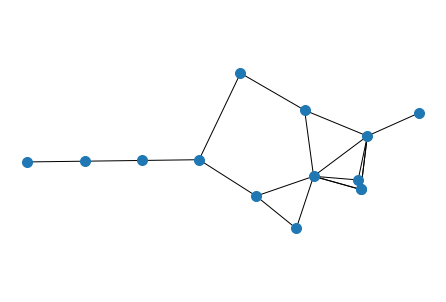

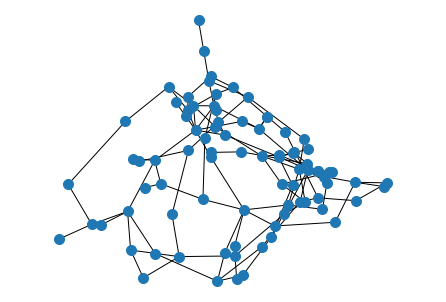

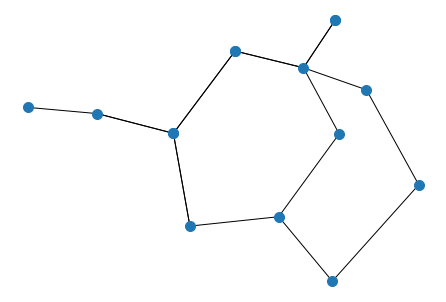

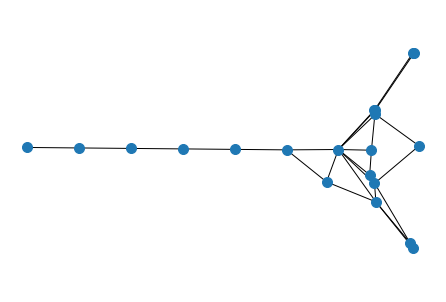

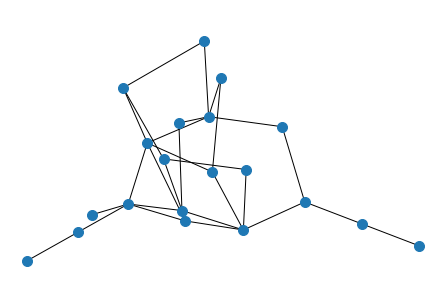

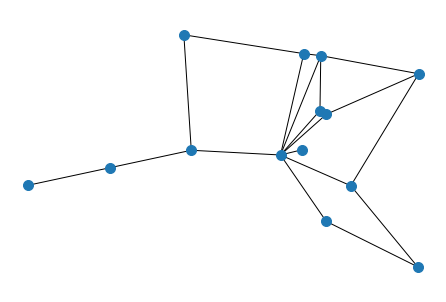

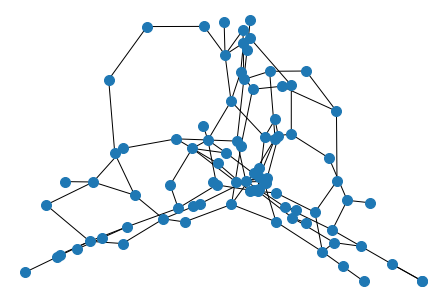

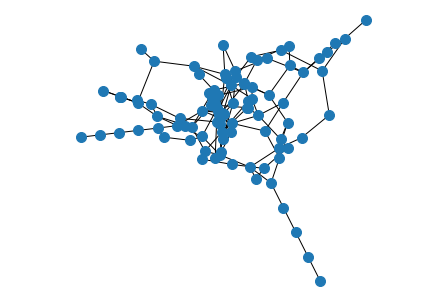

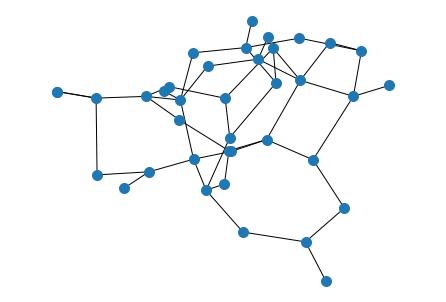

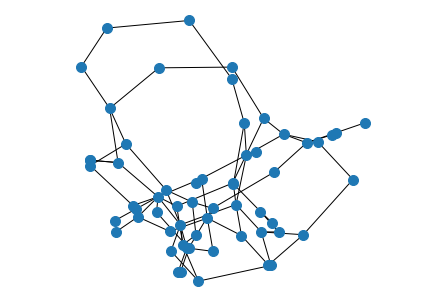

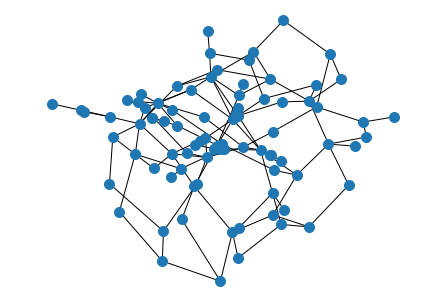

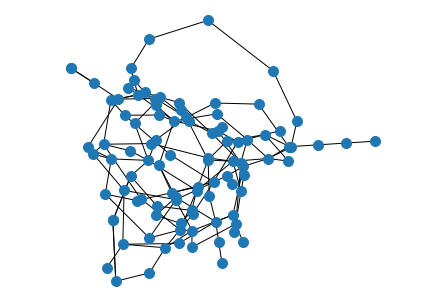

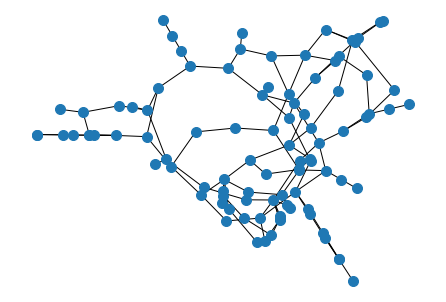

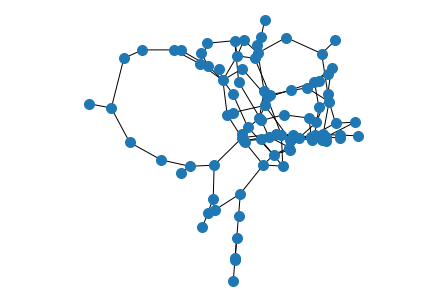

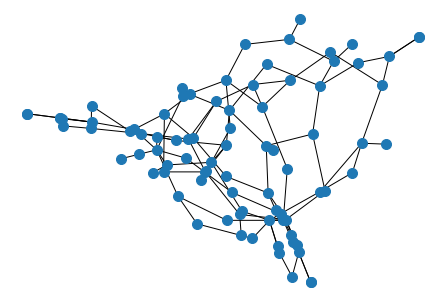

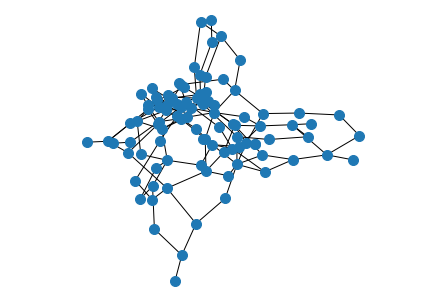

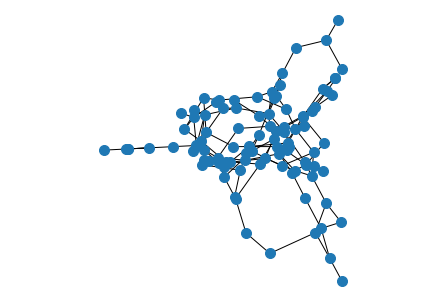

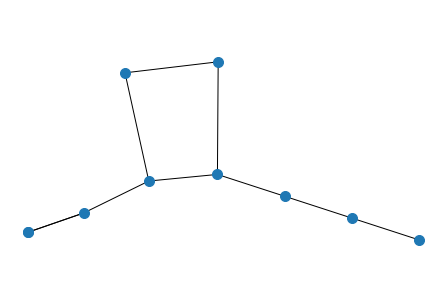

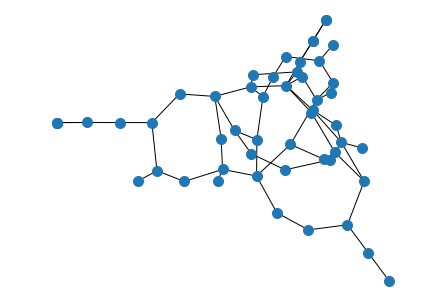

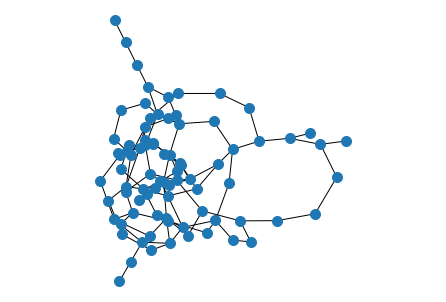

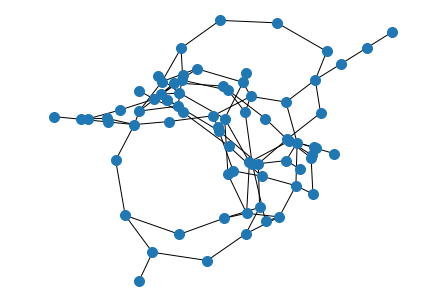

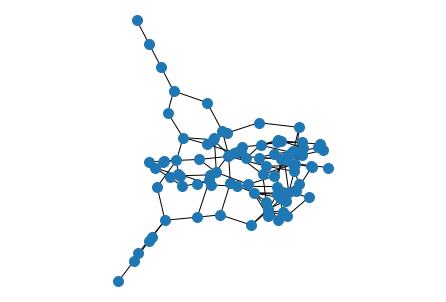

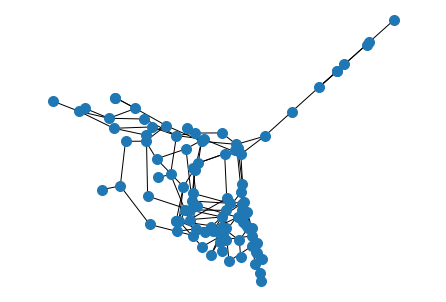

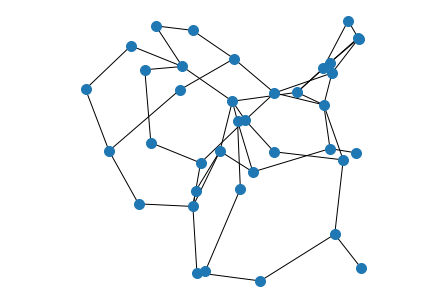

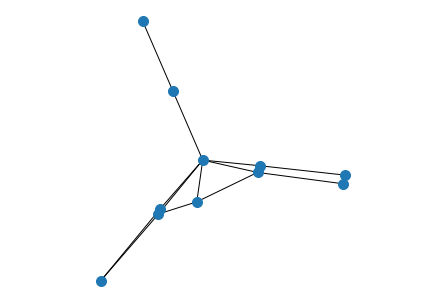

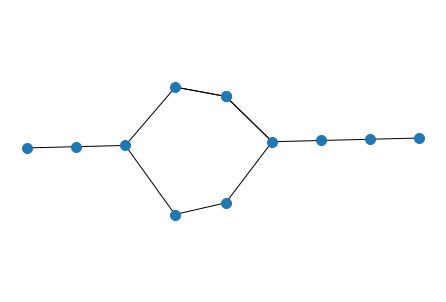

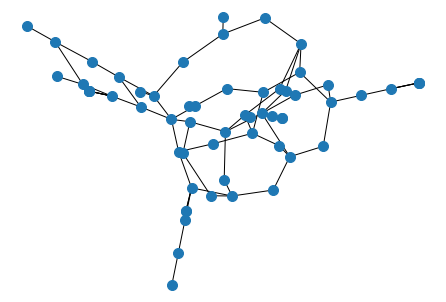

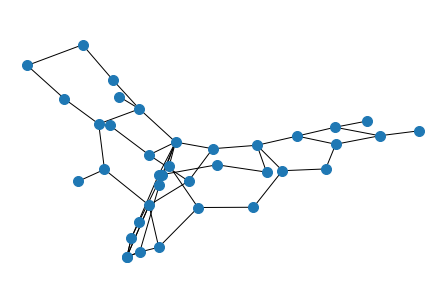

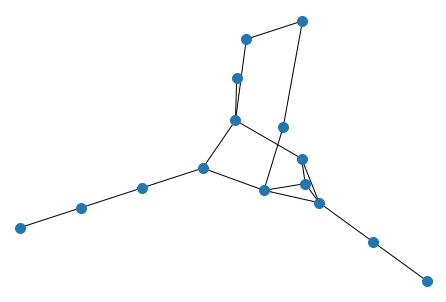

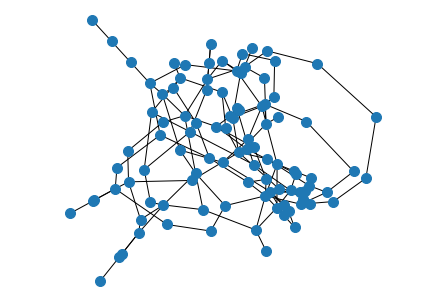

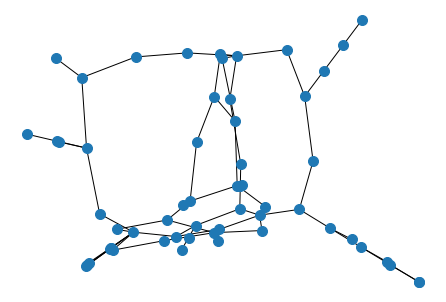

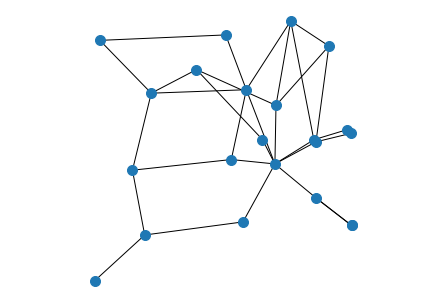

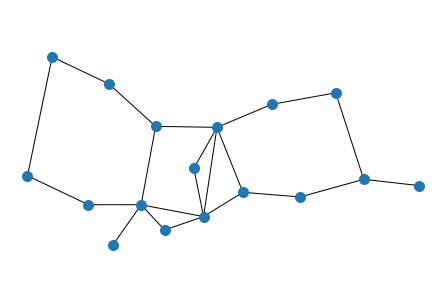

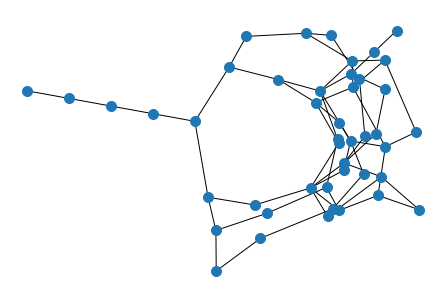

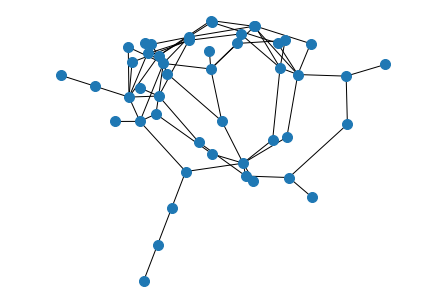

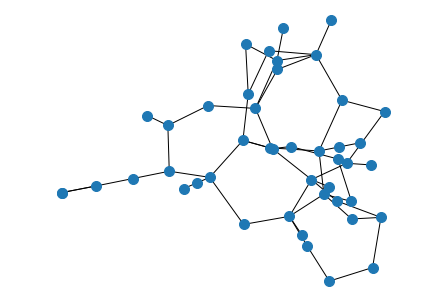

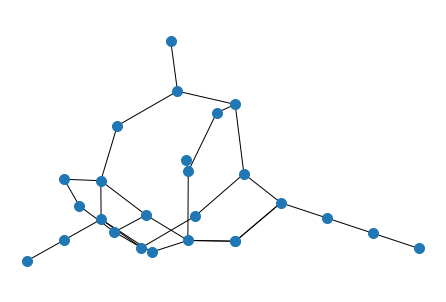

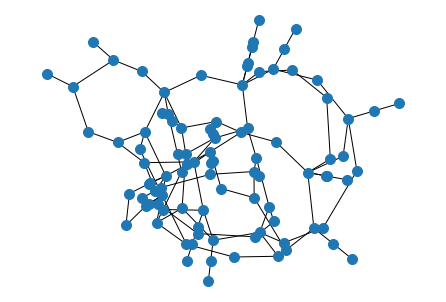

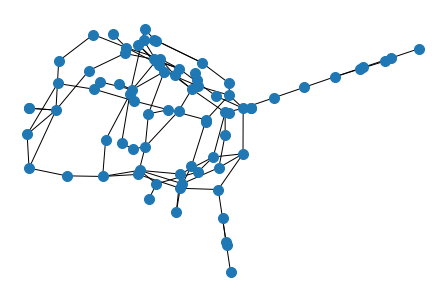

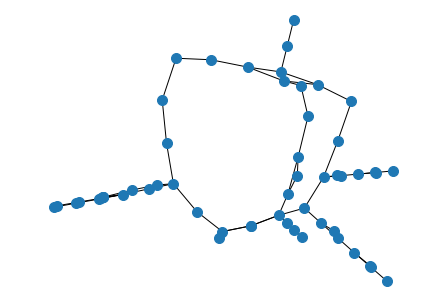

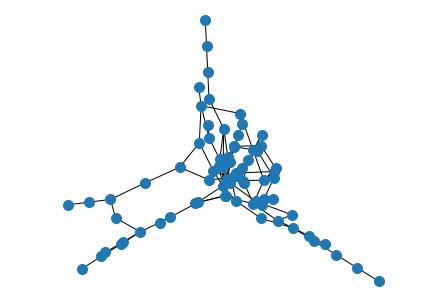

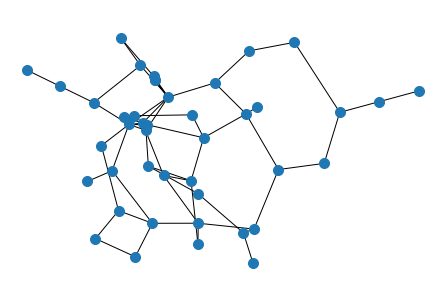

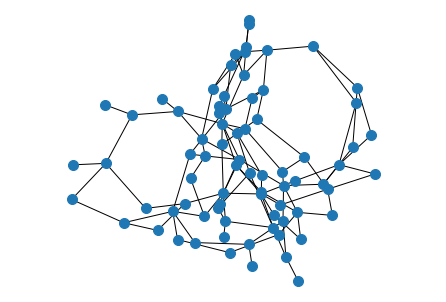

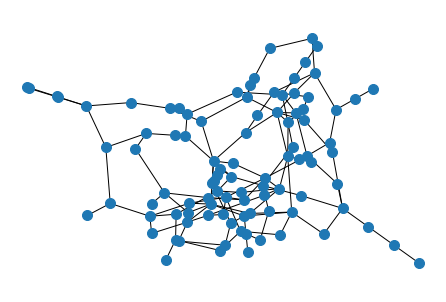

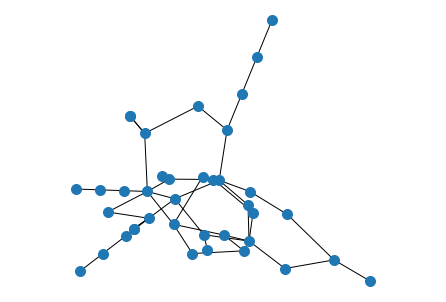

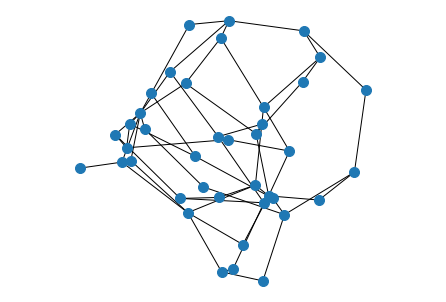

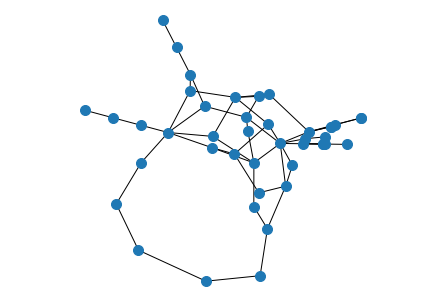

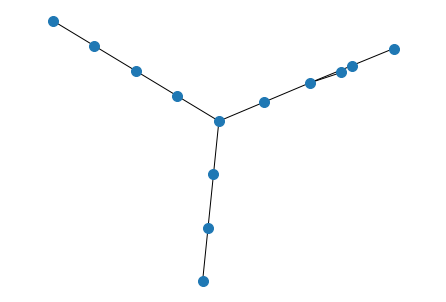

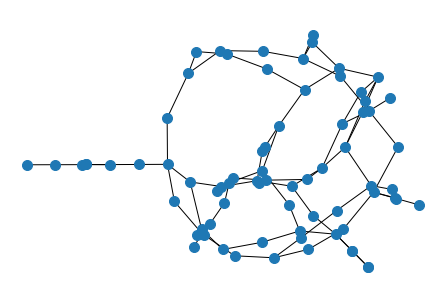

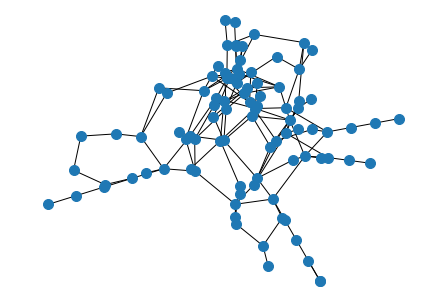

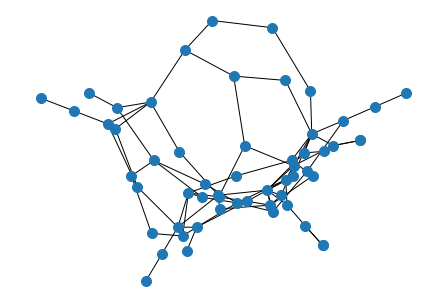

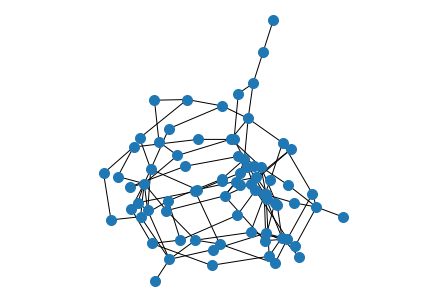

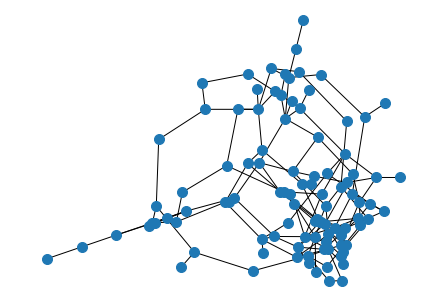

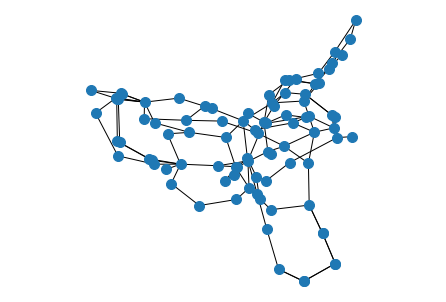

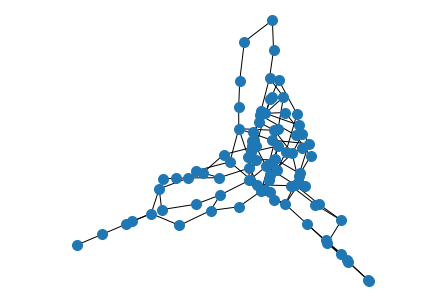

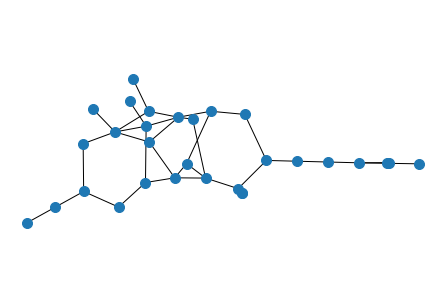

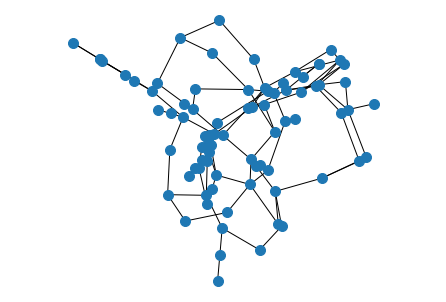

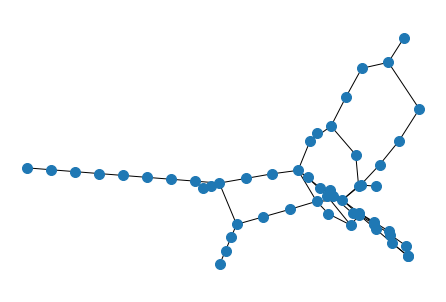

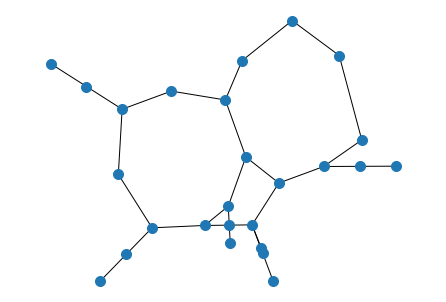

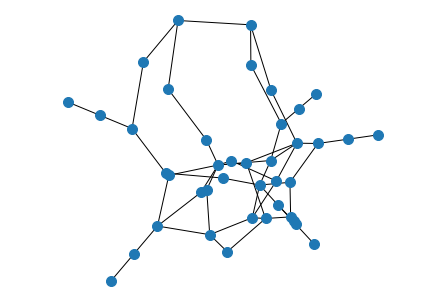

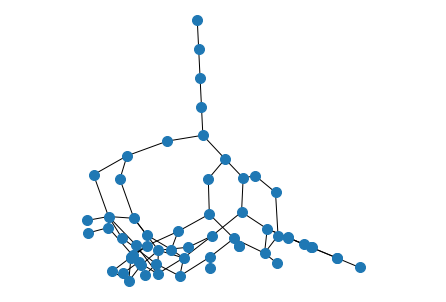

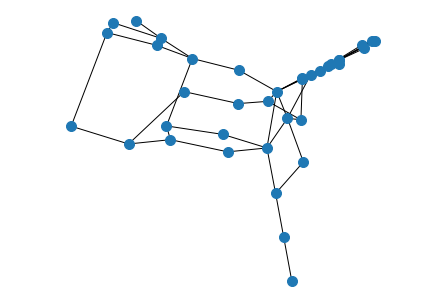

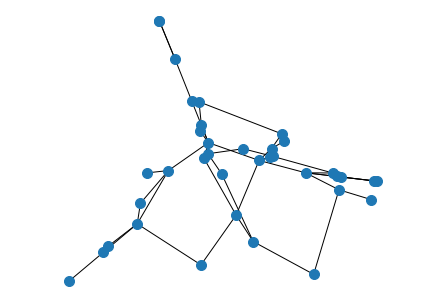

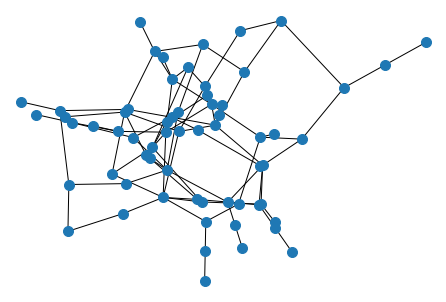

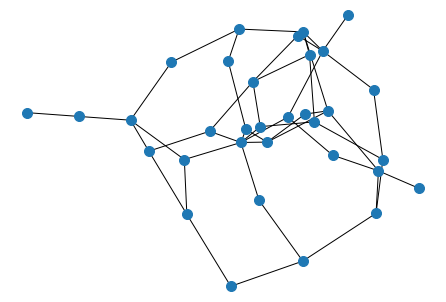

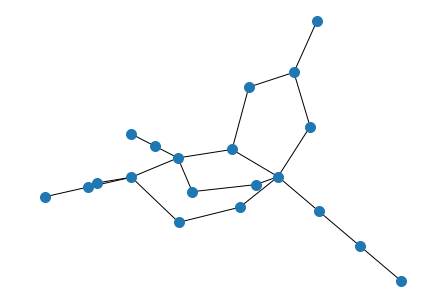

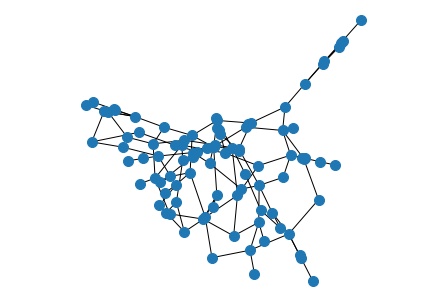

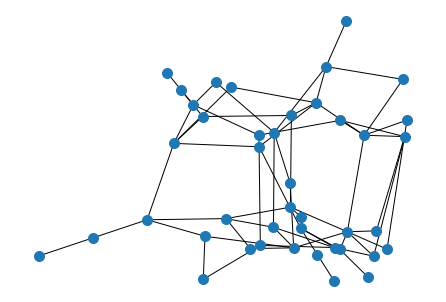

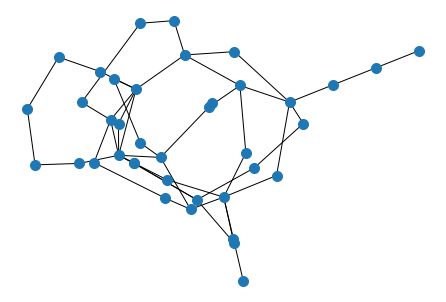

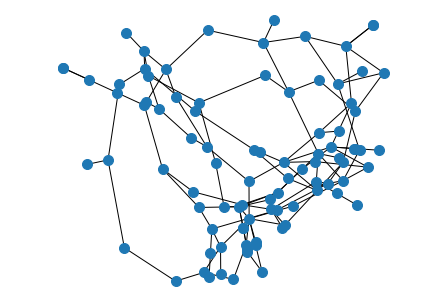

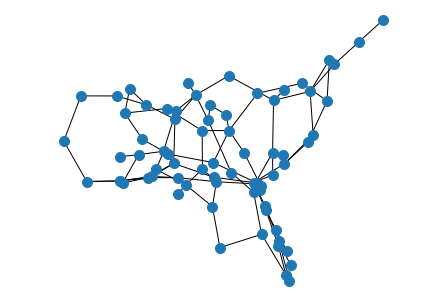

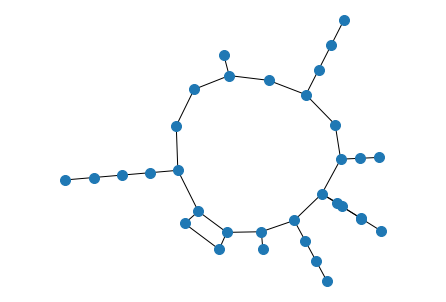

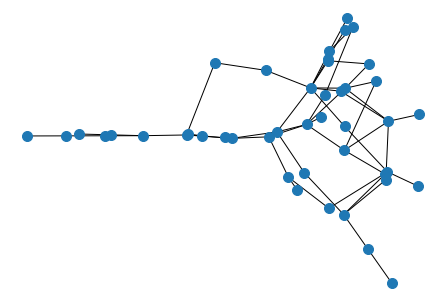

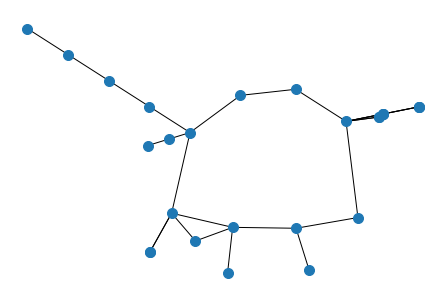

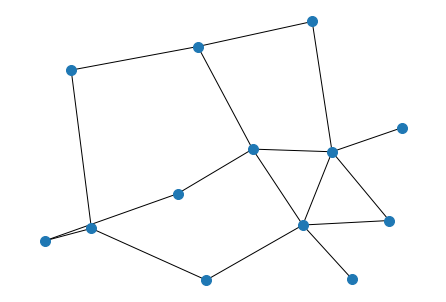

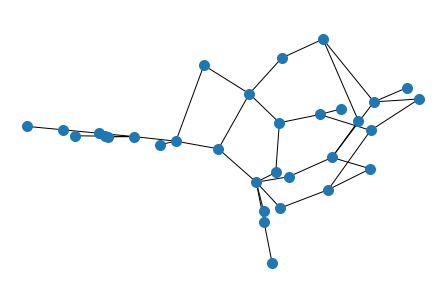

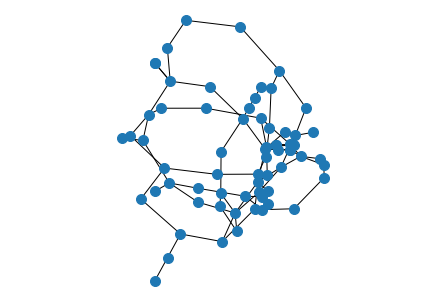

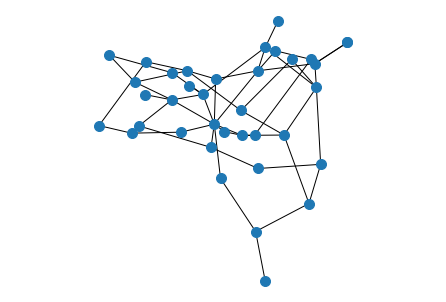

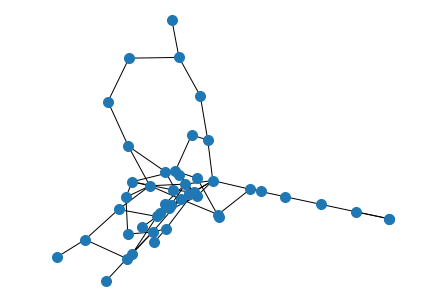

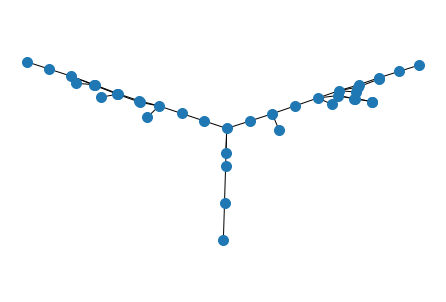

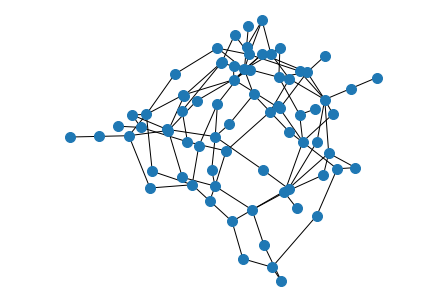

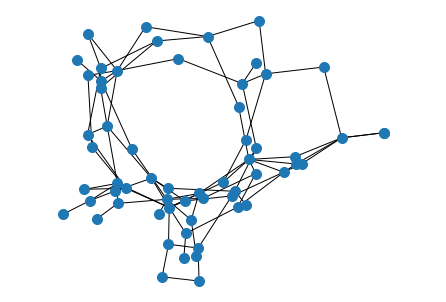

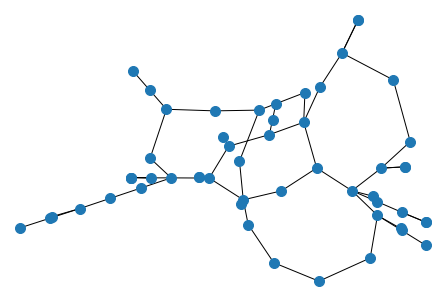

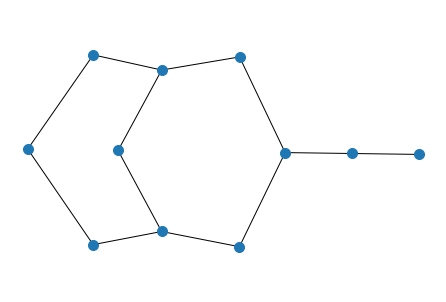

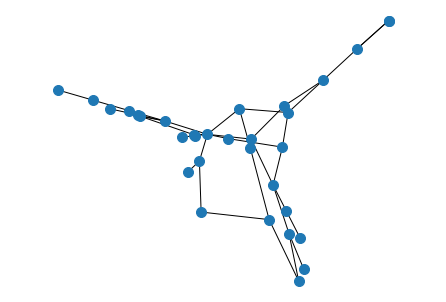

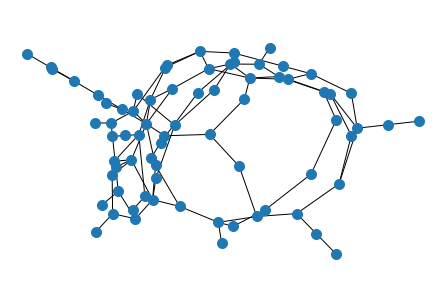

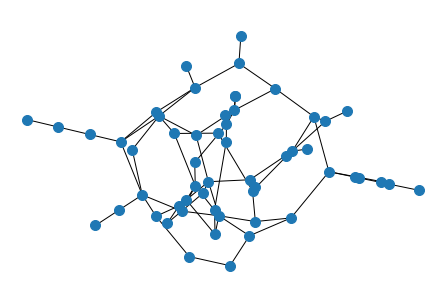

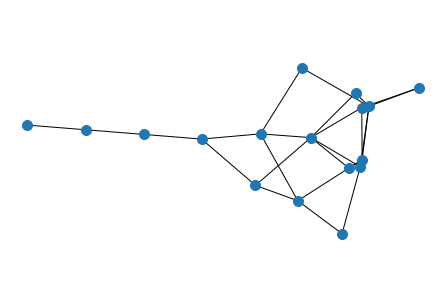

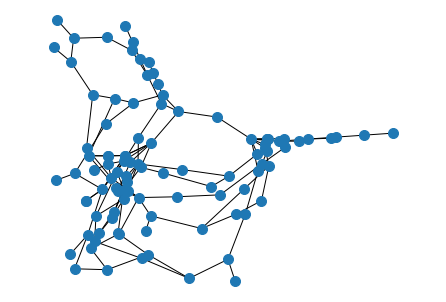

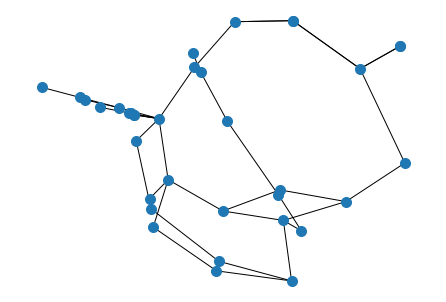

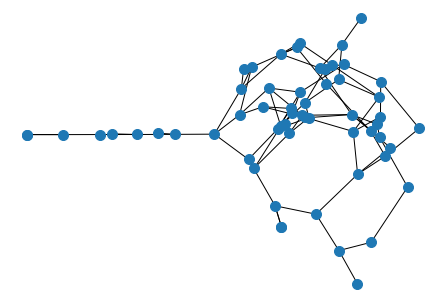

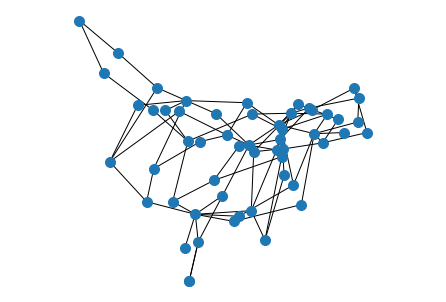

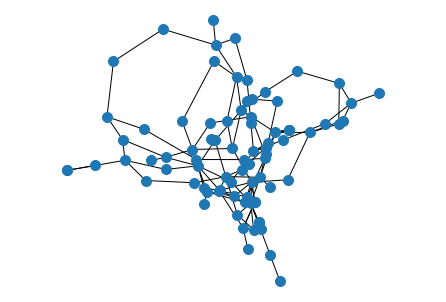

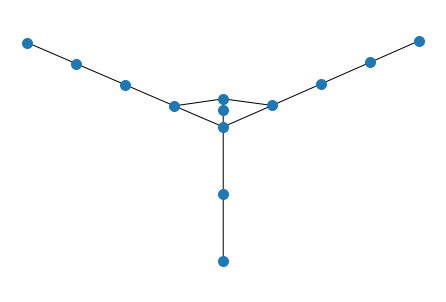

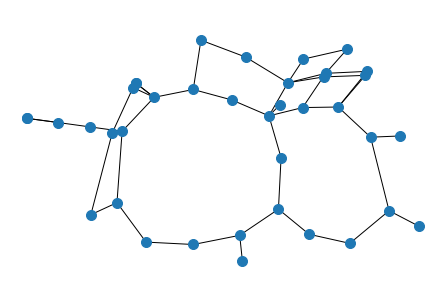

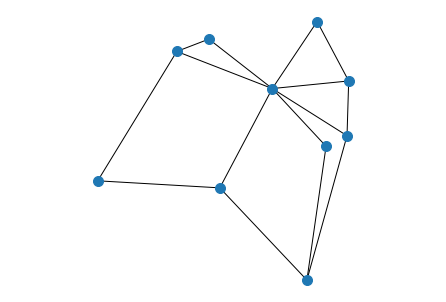

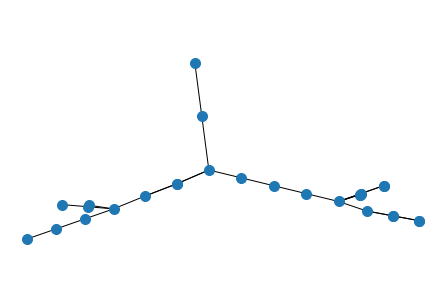

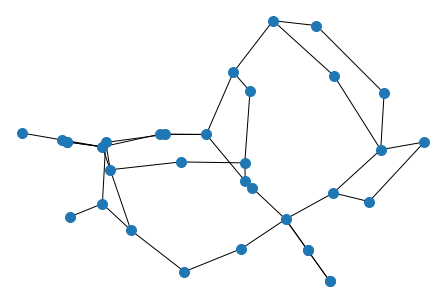

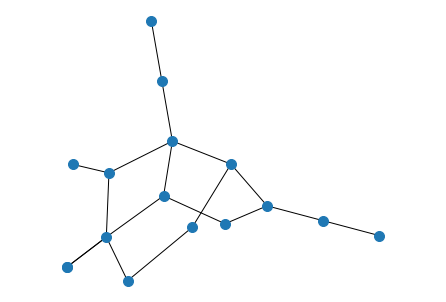

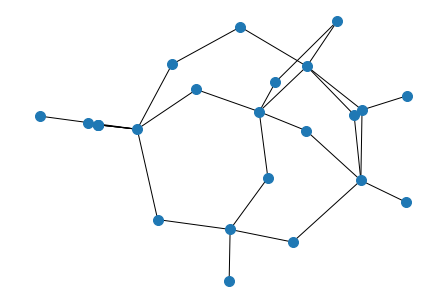

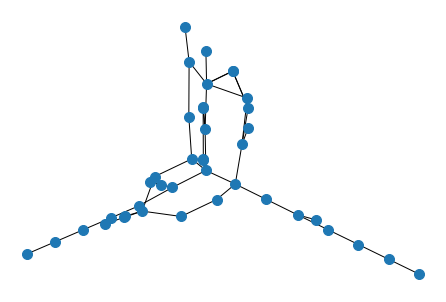

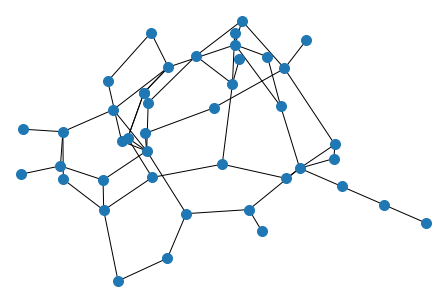

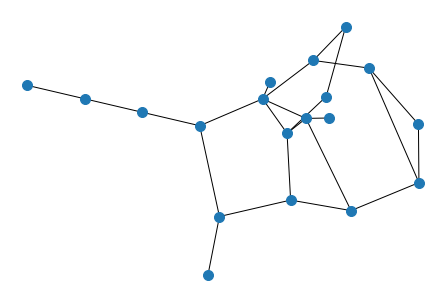

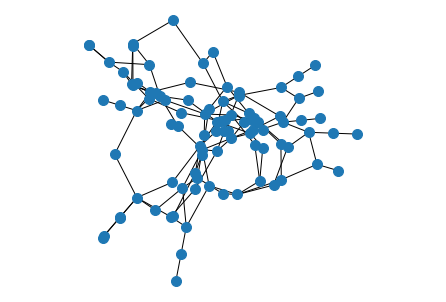

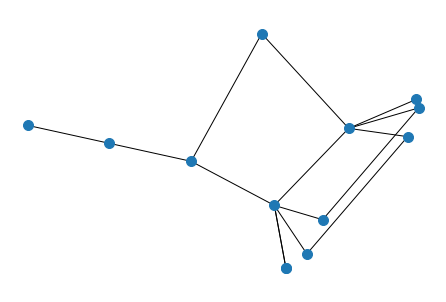

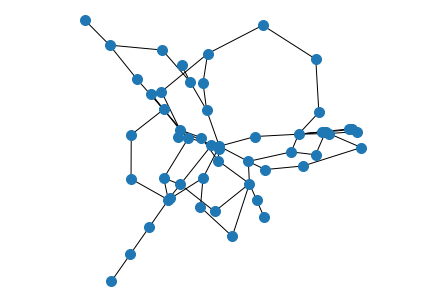

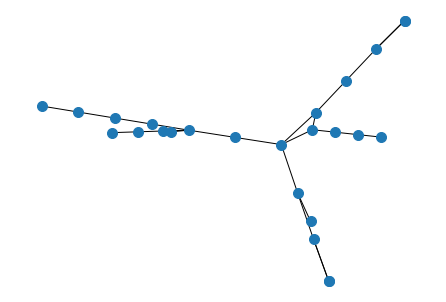

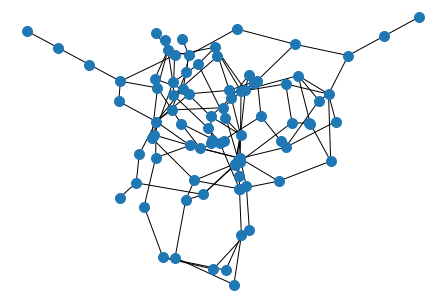

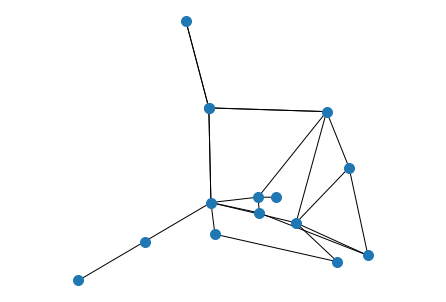

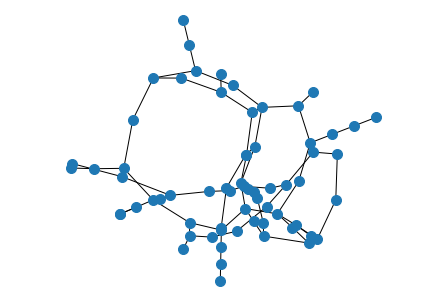

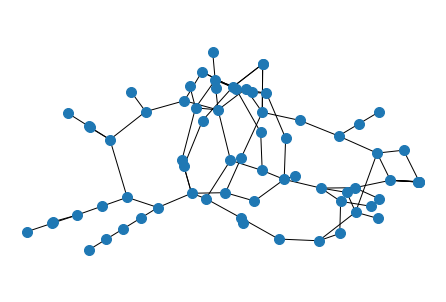

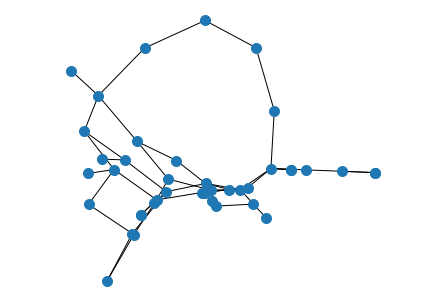

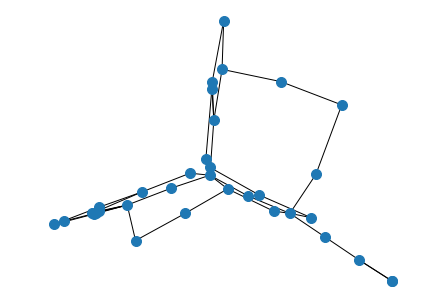

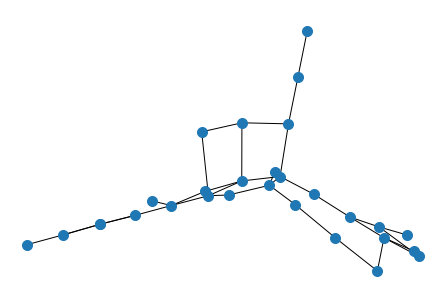

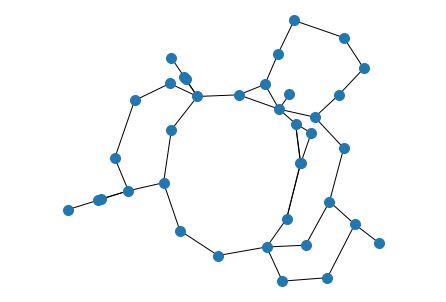

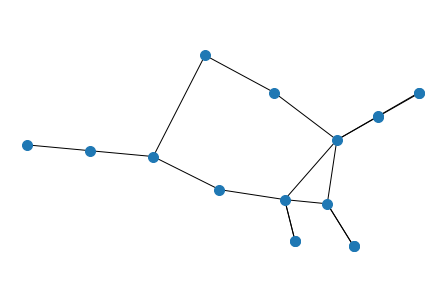

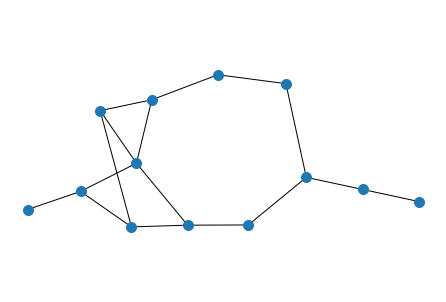

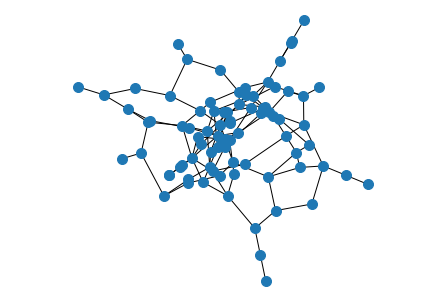

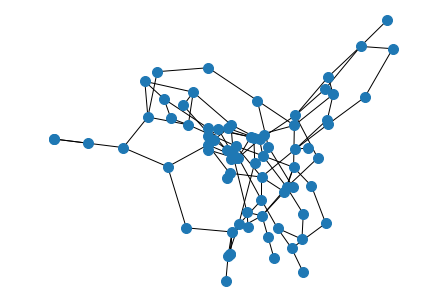

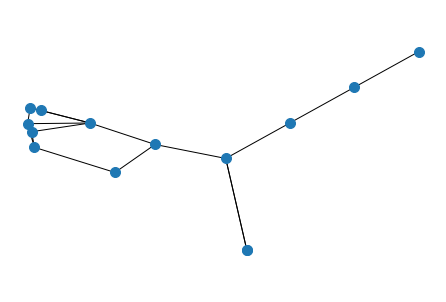

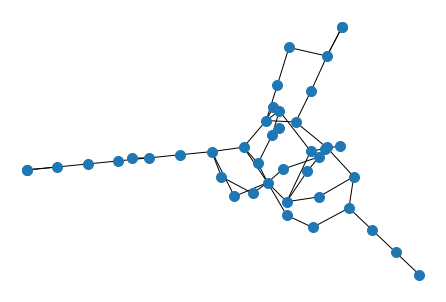

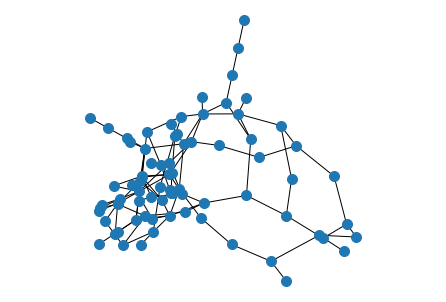

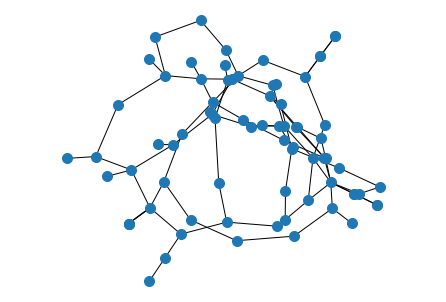

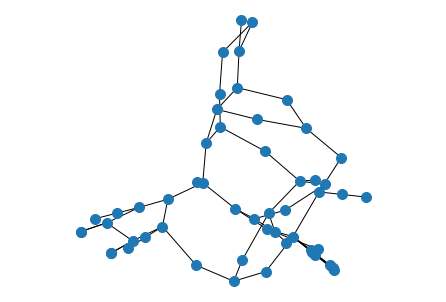

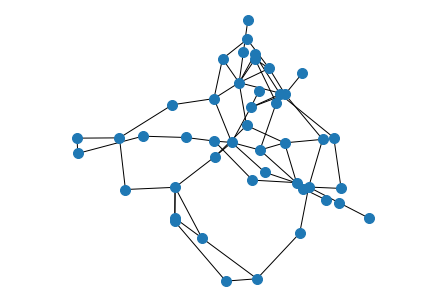

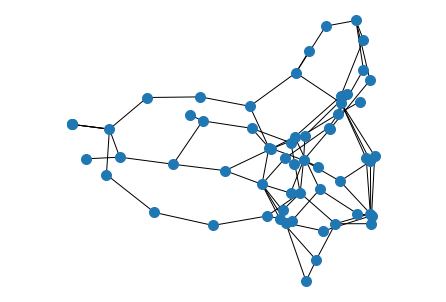

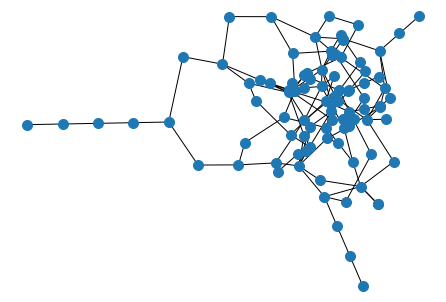

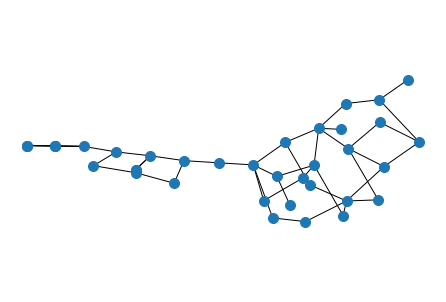

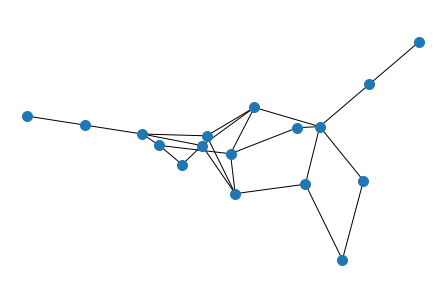

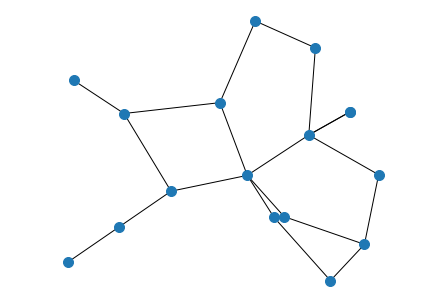

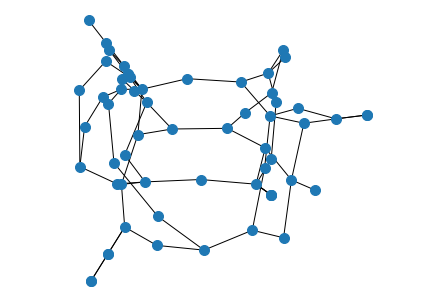

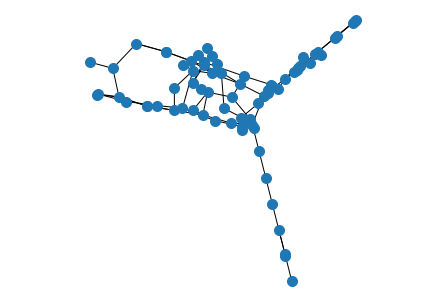

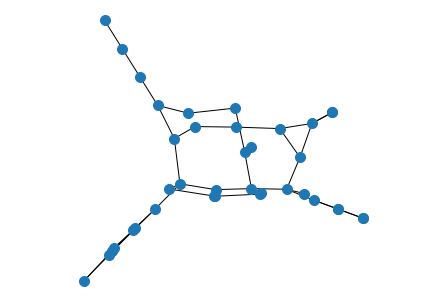

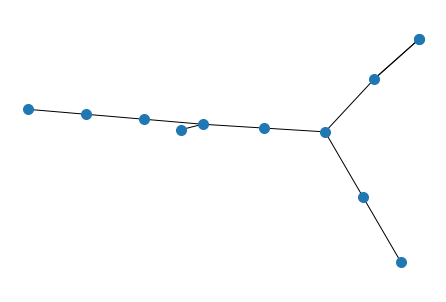

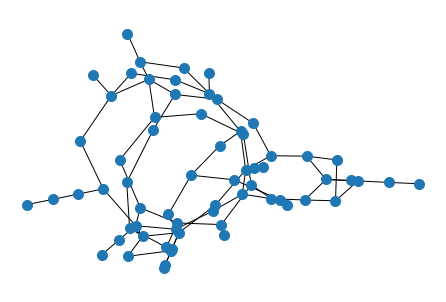

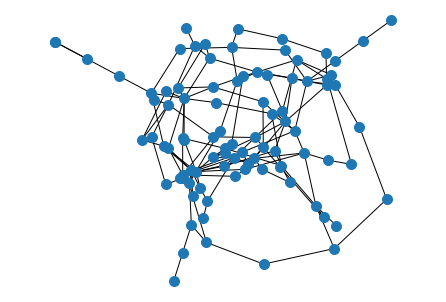

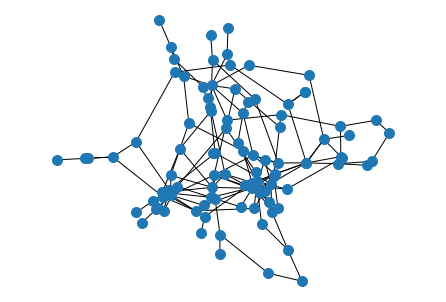

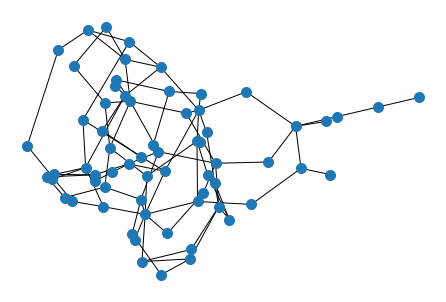

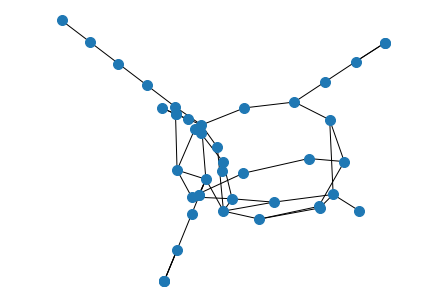

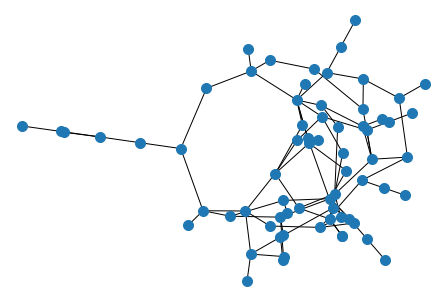

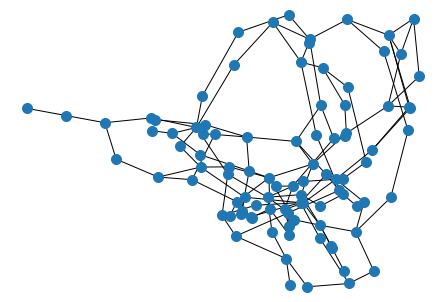

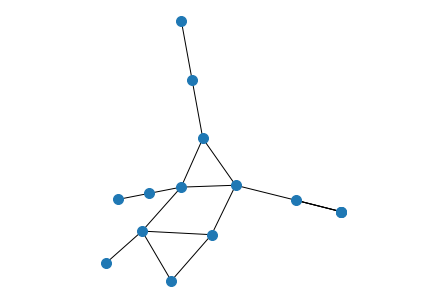

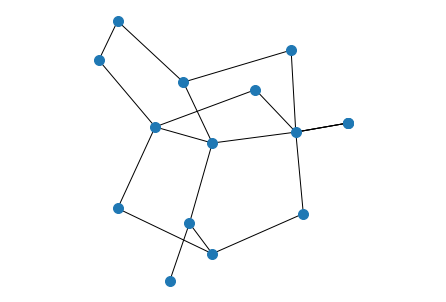

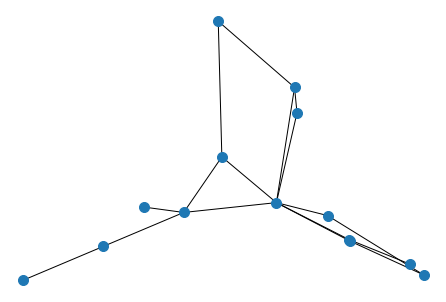

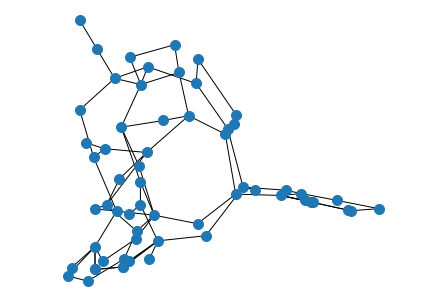

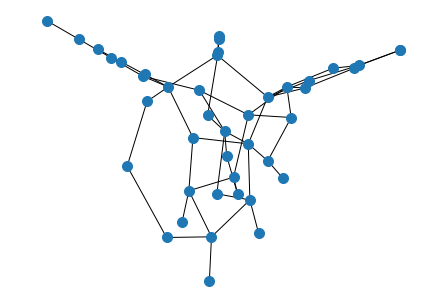

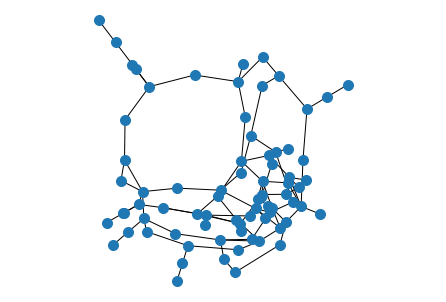

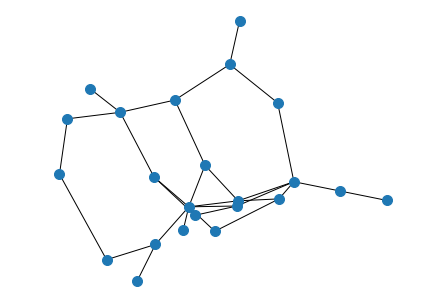

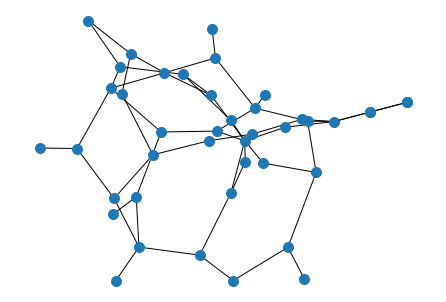

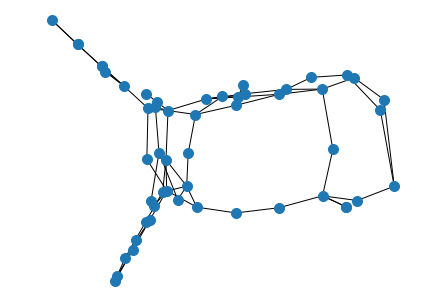

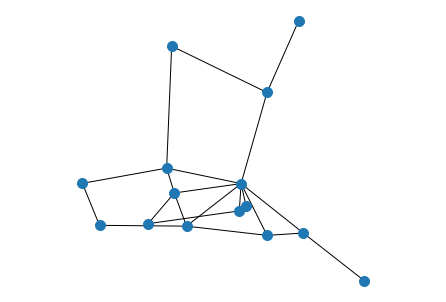

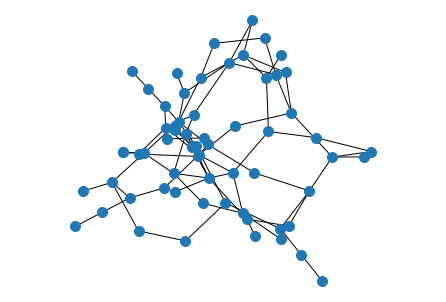

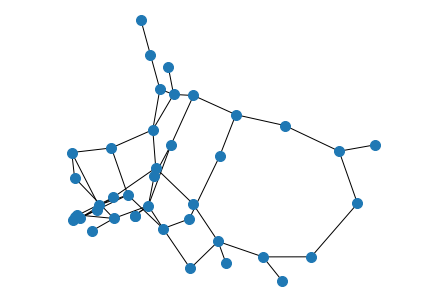

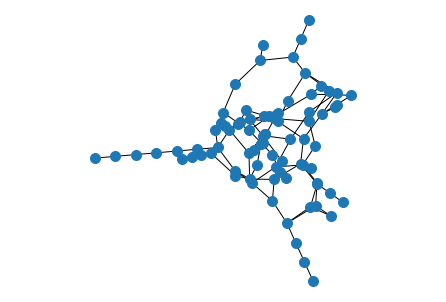

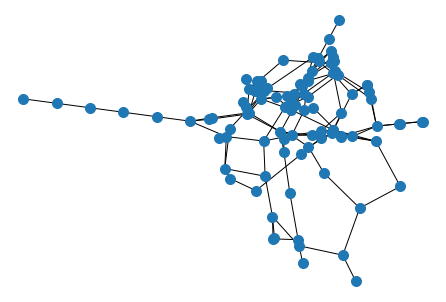

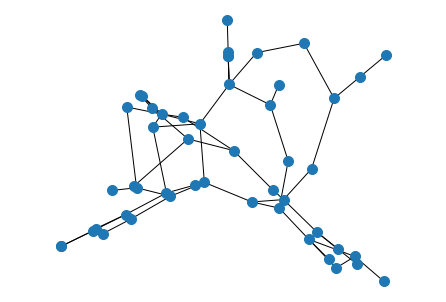

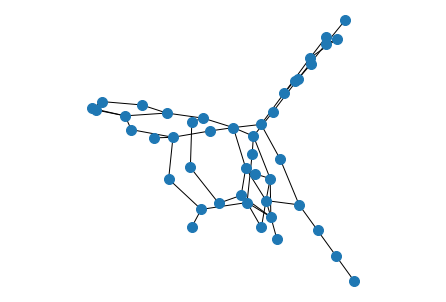

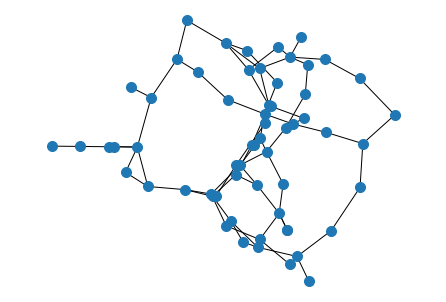

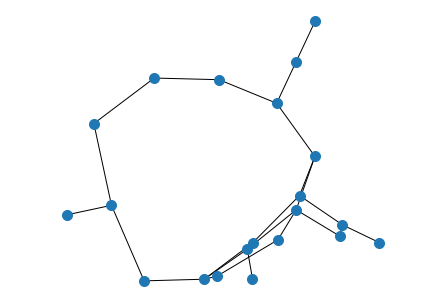

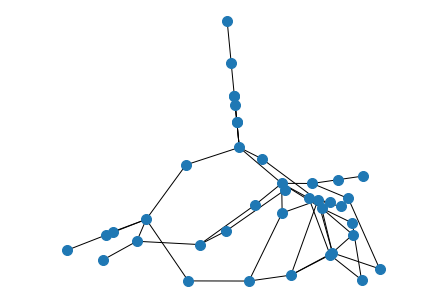

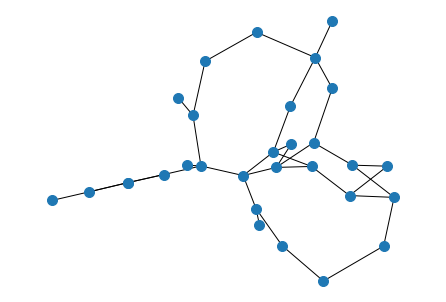

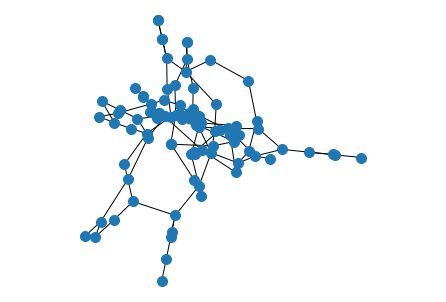

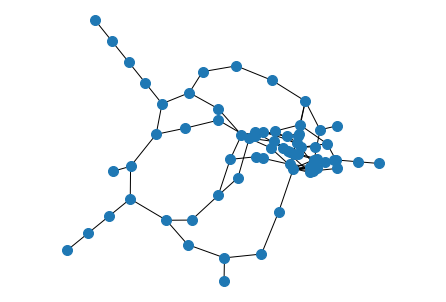

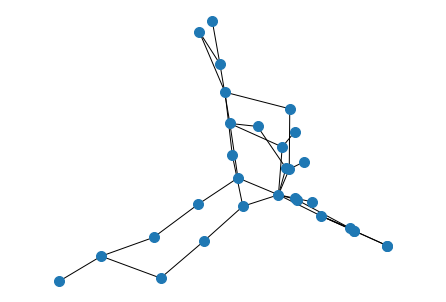

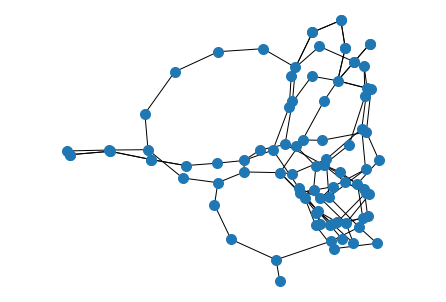

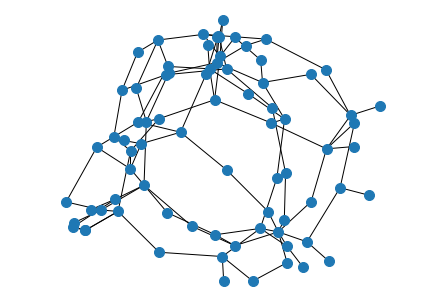

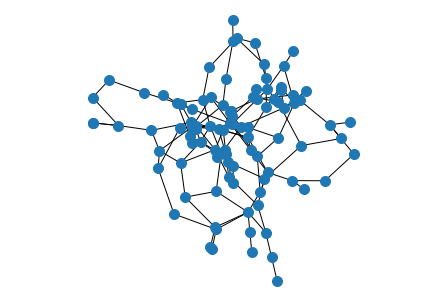

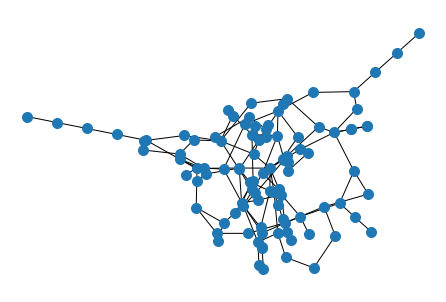

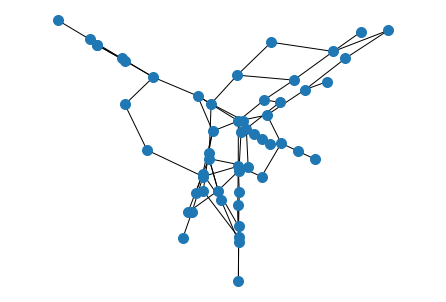

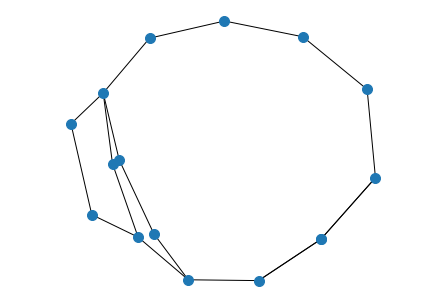

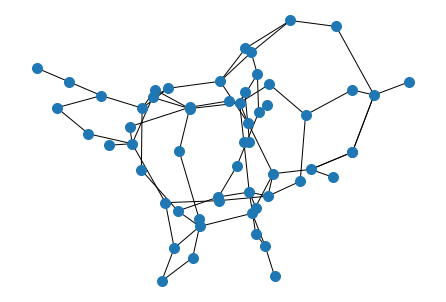

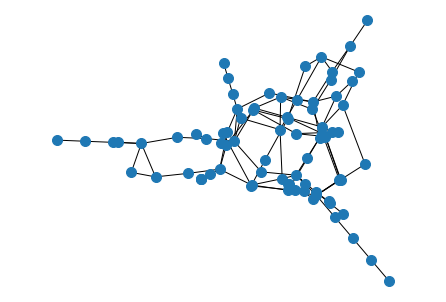

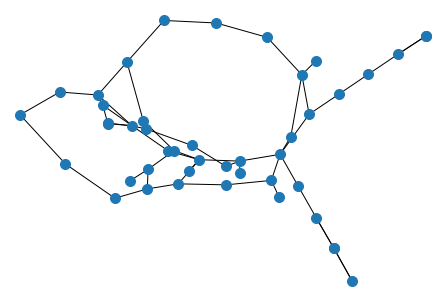

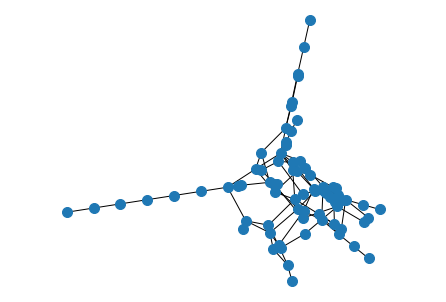

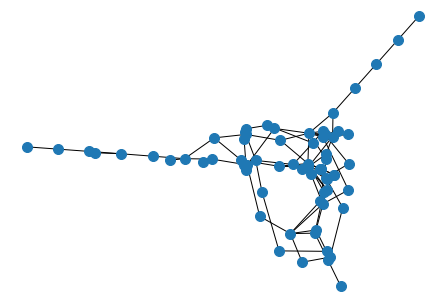

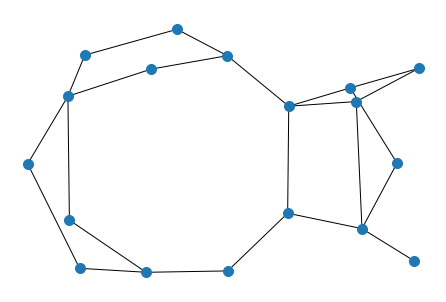

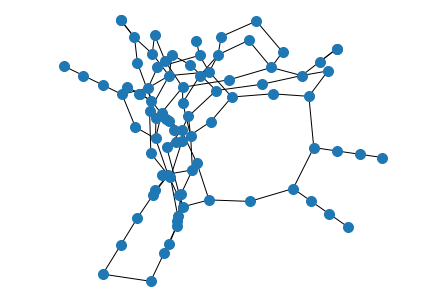

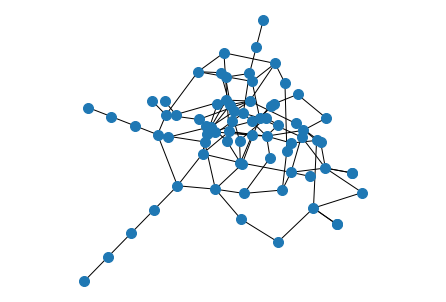

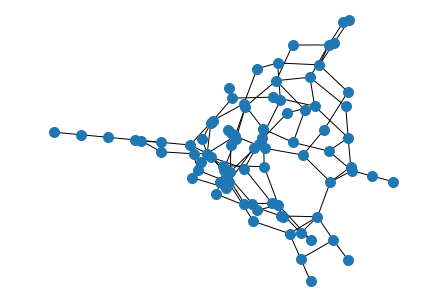

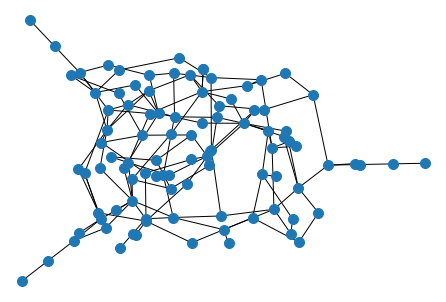

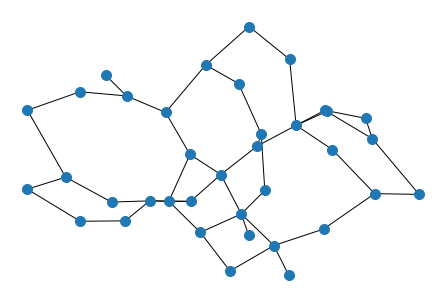

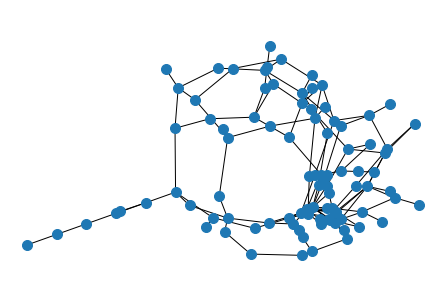

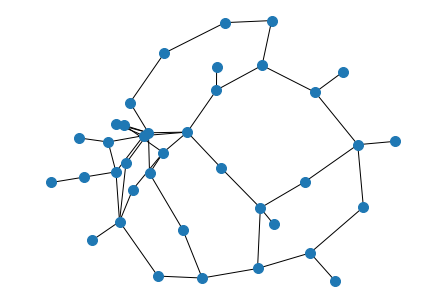

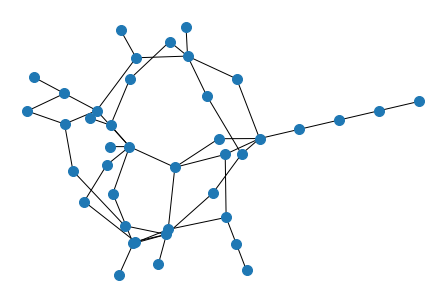

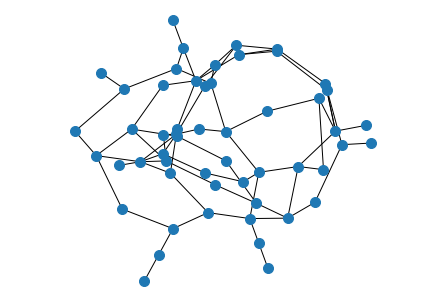

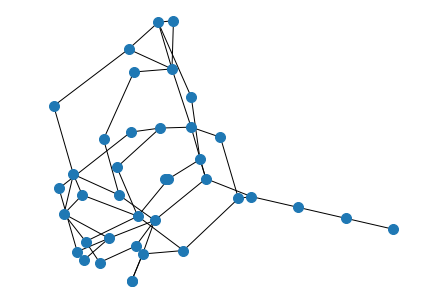

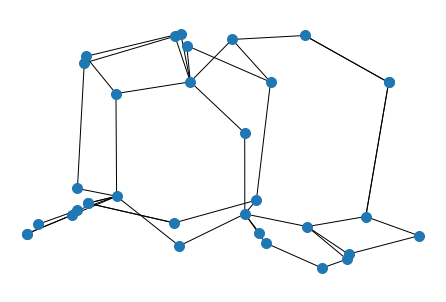

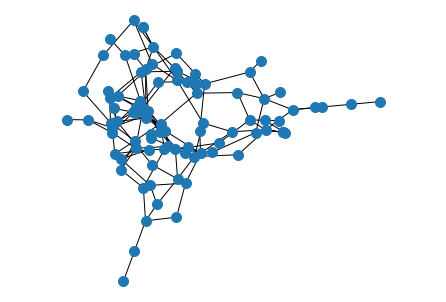

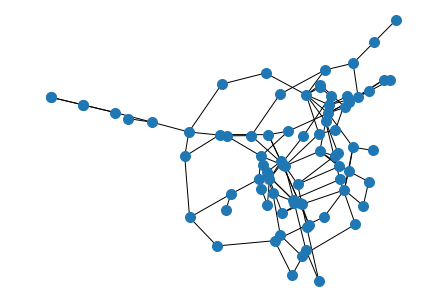

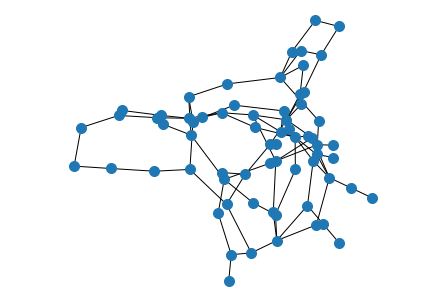

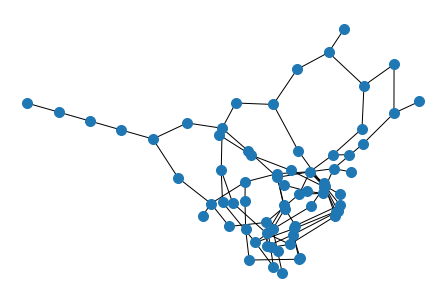

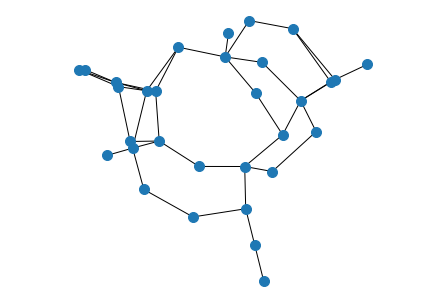

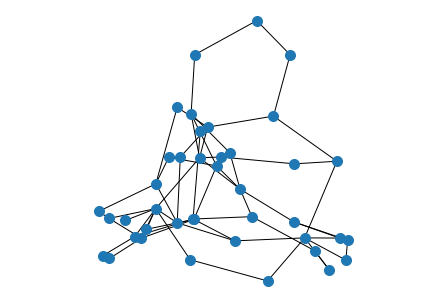

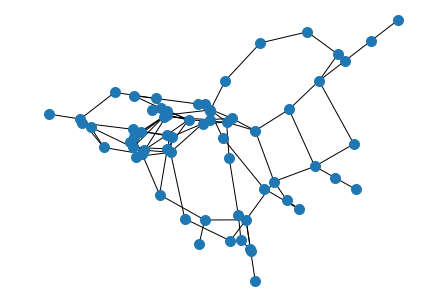

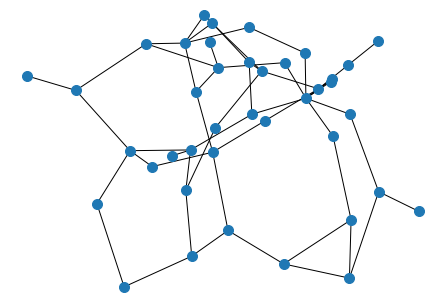

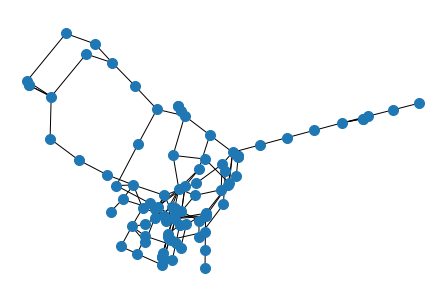

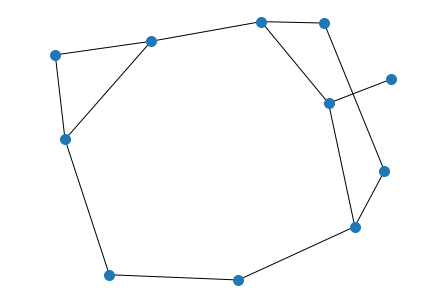

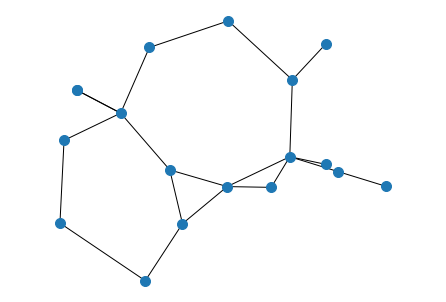

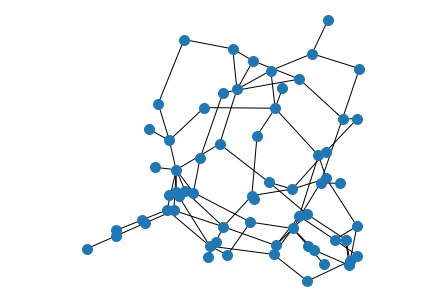

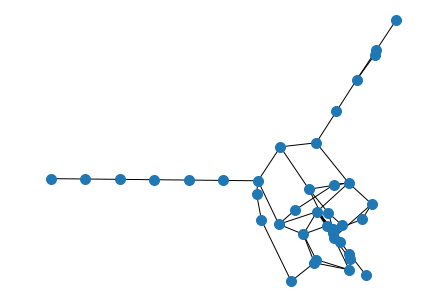

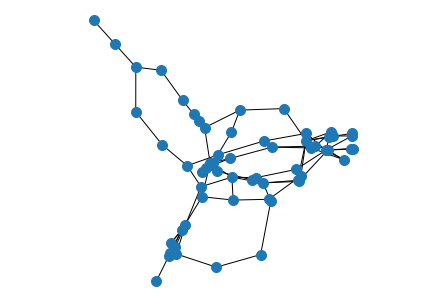

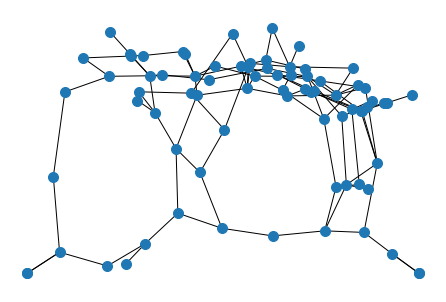

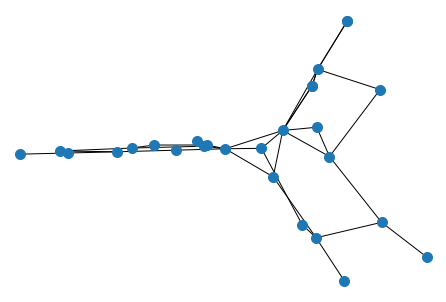

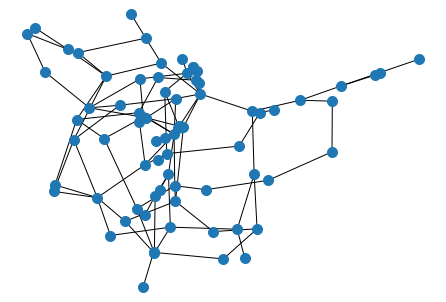

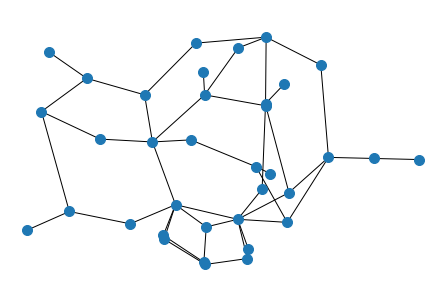

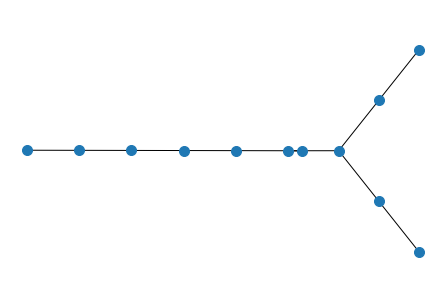

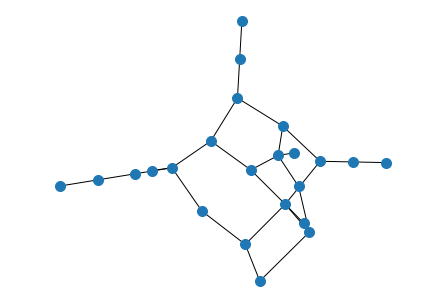

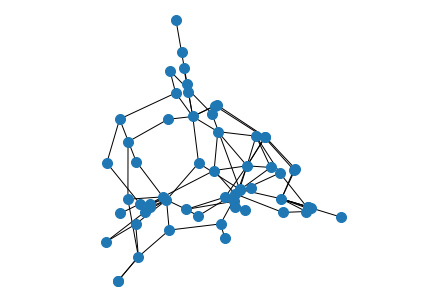

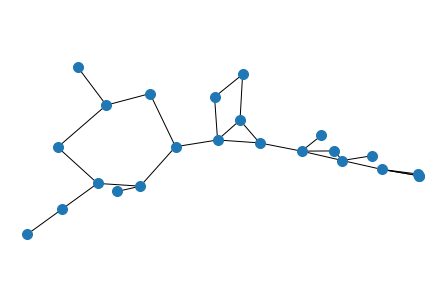

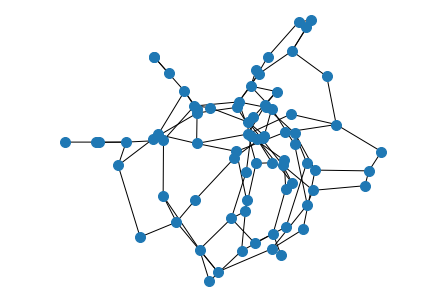

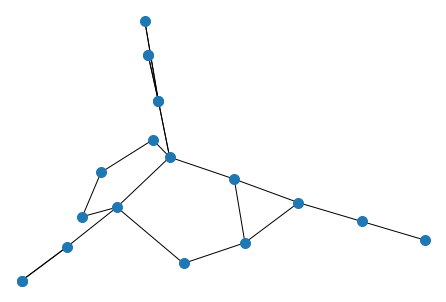

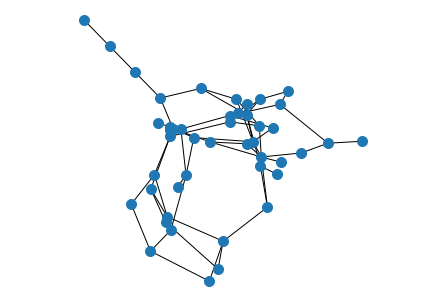

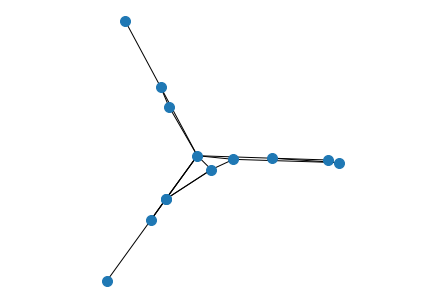

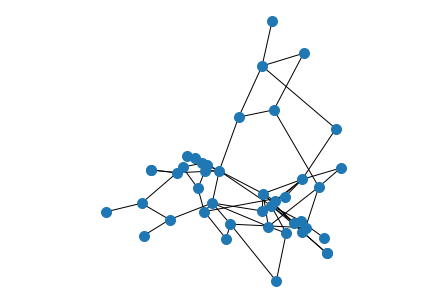

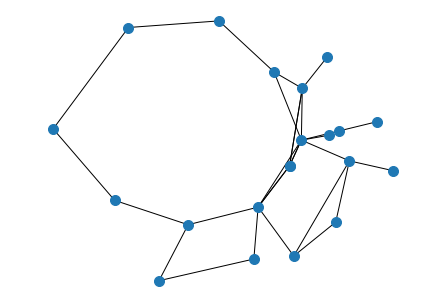

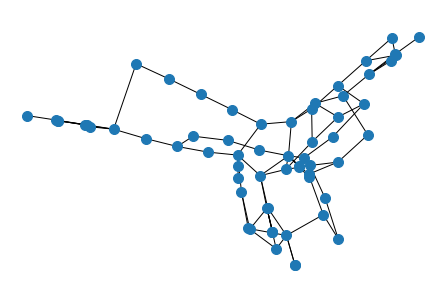

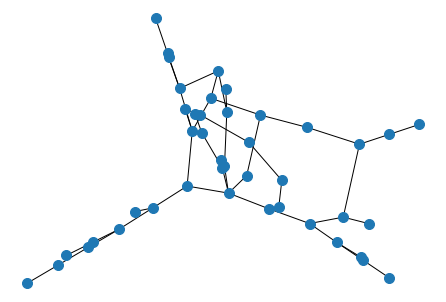

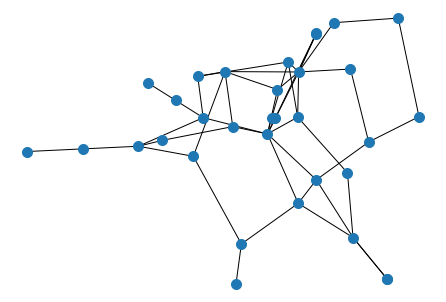

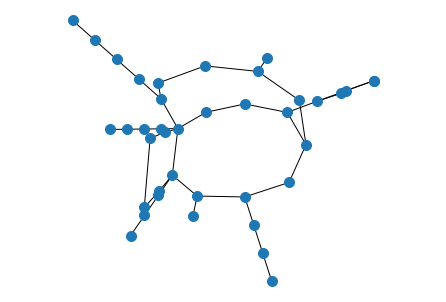

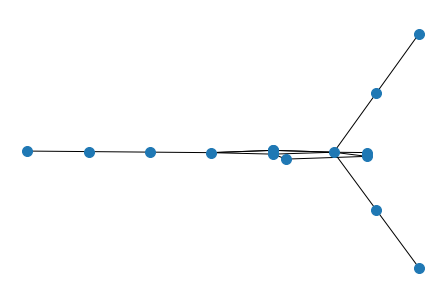

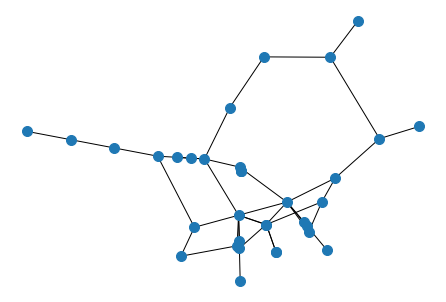

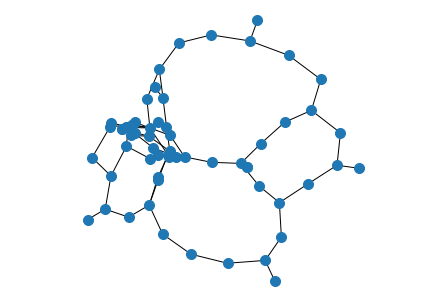

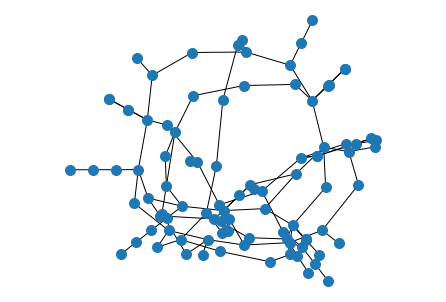

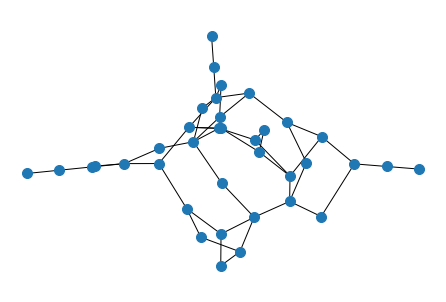

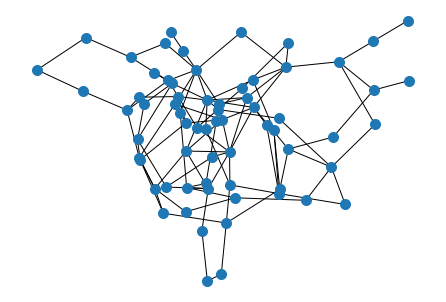

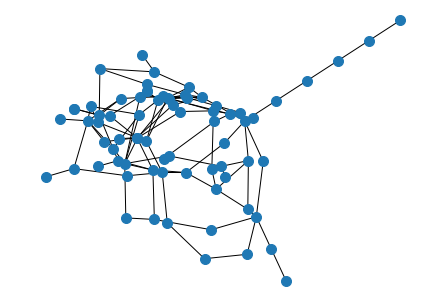

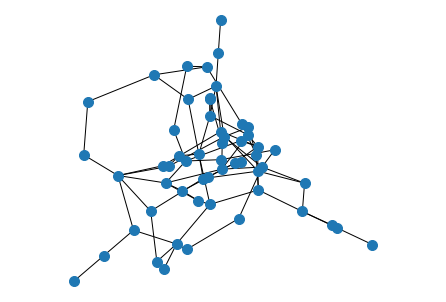

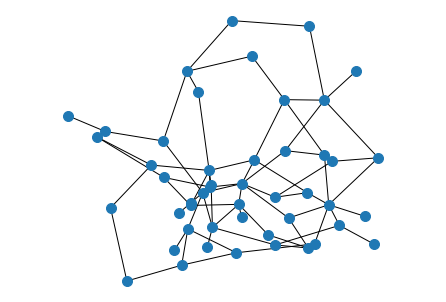

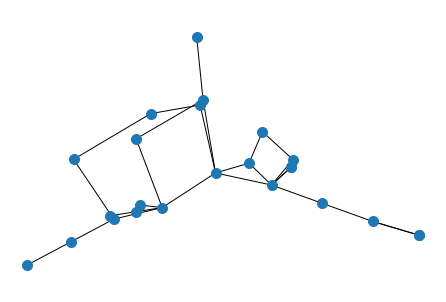

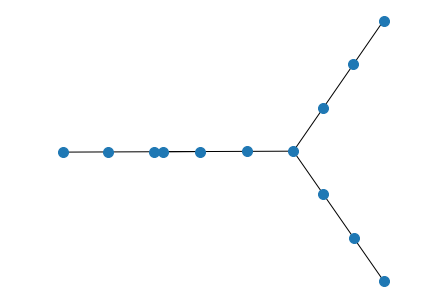

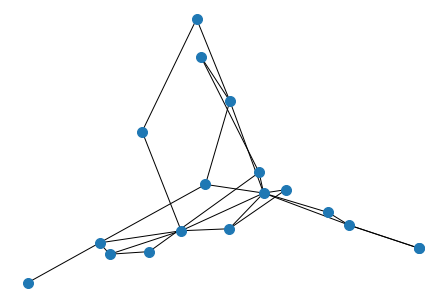

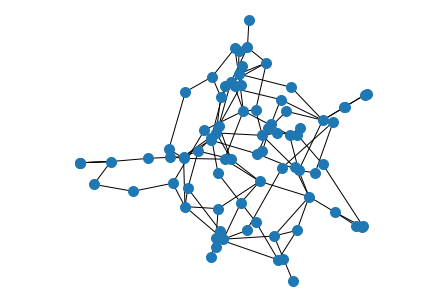

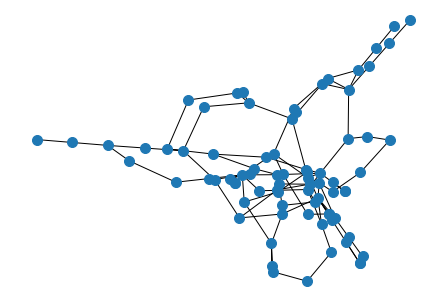

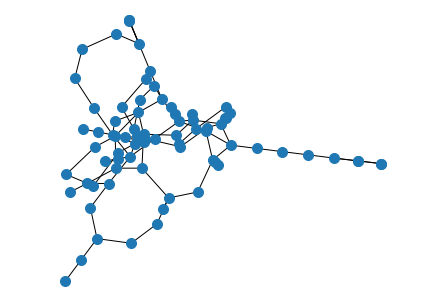

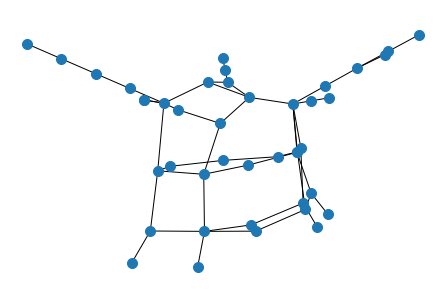

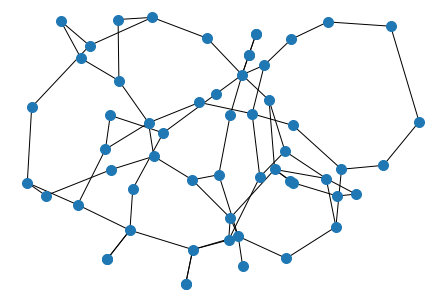

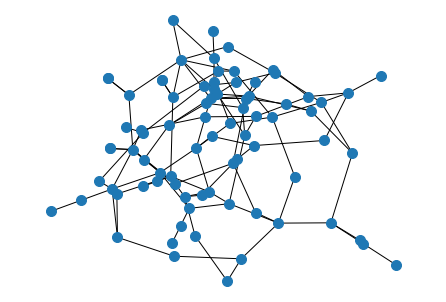

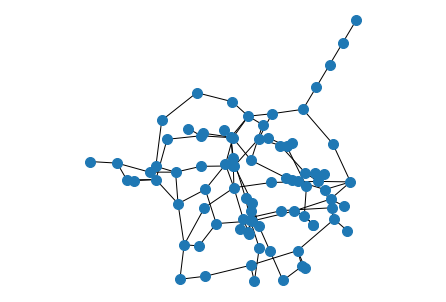

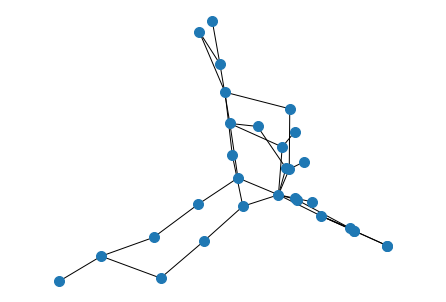

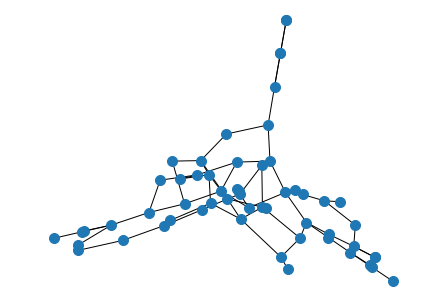

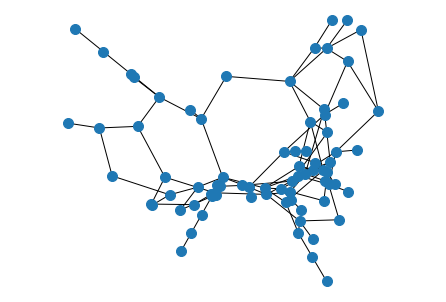

Error in callback <function flush_figures at 0x7f396c977290> (for post_execute):


KeyboardInterrupt: 

In [25]:
test_metrics = test(model=model, 
                    criteria_list=evaluation_criteria, 
                    dataset=data_list, 
                    idx_range=range(10000, 11000), 
                    callback=test_callback)
pickle.dump(test_metrics, open(metrics_file("test"), "wb"))

In [27]:
metrics = test_metrics
print('stress:', metrics['stress'].mean())
print('stress_spc:', metrics['stress_spc'].mean())
print('l1_angle:', metrics['l1_angle'].mean())
print('l1_angle_spc:', metrics['l1_angle_spc'].mean())
print('edge:', metrics['edge'].mean())
print('edge_spc:', metrics['edge_spc'].mean())
print('ring:', metrics['ring'].mean())
print('ring_spc:', metrics['ring_spc'].mean())
print('tsne:', metrics['tsne'].mean())
print('reso_score:', metrics['resolution_score'].mean())
print('min_angle:', metrics['min_angle'].mean())

stress: tensor(372.0605)
stress_spc: tensor(0.3653)
l1_angle: tensor(93.1191)
l1_angle_spc: tensor(0.1446)
edge: tensor(0.2131)
edge_spc: tensor(0.5972)
ring: tensor(280.9692)
ring_spc: tensor(0.2075)
tsne: tensor(0.2458)
reso_score: tensor(0.5454)
min_angle: tensor(1.4416)


In [28]:
pickle.dump(metrics, open('pmds_metrics.pickle', 'wb'))

In [29]:
gt_pmds = pd.DataFrame()
gt_pmds['stress'] = metrics['stress']
gt_pmds['l1_angle'] = metrics['l1_angle']
gt_pmds['edge'] = metrics['edge']
gt_pmds['ring'] = metrics['ring']
gt_pmds['tsne'] = metrics['tsne']
gt_pmds['index'] = range(10000, 11000)
gt_pmds

stress    l1_angle      edge        ring      tsne  index
0     969.097534  146.581268  0.198556  492.282623  0.344242  10000
1     140.401657   94.512527  0.216259  161.379364  0.221358  10001
2     195.234924   94.483734  0.278883  190.750290  0.229397  10002
3      69.535492   48.845406  0.179200   89.546631  0.177983  10003
4     401.096985   96.141823  0.182002  358.181274  0.258446  10004
..           ...         ...       ...         ...       ...    ...
995   367.882263   96.412354  0.220272  304.851257  0.258795  10995
996    53.745419   43.446175  0.136656   76.395844  0.159706  10996
997   183.333679   74.953842  0.201425  188.129486  0.257211  10997
998    48.788818   33.852112  0.220484   64.860092  0.178737  10998
999  1343.362549  182.768570  0.338054  840.978149  0.399113  10999

[1000 rows x 6 columns]

In [31]:
gt_pmds.to_csv('gt_pmds.csv', index=False)